# Waymo Emergency Vehicle Detection with YOLO

### Initializing Data from GCP Bucket

In [2]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from google.cloud import storage
import shutil

# Install required packages if needed
# !pip install -q google-cloud-storage

# Authenticate to Google Cloud
from google.colab import auth
auth.authenticate_user()

# Define directories
BASE_DIR = "/content/waymo_emergency_vehicle_detection"
DATA_DIR = os.path.join(BASE_DIR, "data")
VIDEOS_DIR = os.path.join(DATA_DIR, "videos")
FRAMES_DIR = os.path.join(DATA_DIR, "frames")
LABELS_DIR = os.path.join(DATA_DIR, "labels")
YOLO_DIR = os.path.join(BASE_DIR, "yolo_dataset")

# Create directories
for directory in [DATA_DIR, VIDEOS_DIR, FRAMES_DIR, LABELS_DIR, YOLO_DIR]:
    os.makedirs(directory, exist_ok=True)

# Split directories
for split in ["train", "val"]:
    os.makedirs(os.path.join(VIDEOS_DIR, split), exist_ok=True)
    os.makedirs(os.path.join(FRAMES_DIR, split), exist_ok=True)
    os.makedirs(os.path.join(LABELS_DIR, split), exist_ok=True)
    os.makedirs(os.path.join(YOLO_DIR, split), exist_ok=True)
    os.makedirs(os.path.join(YOLO_DIR, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(YOLO_DIR, split, "labels"), exist_ok=True)

# Initialize GCP client
client = storage.Client()
bucket_name = "waymo_open_dataset_road_plus_plus"
bucket = client.bucket(bucket_name)

In [3]:
# List all blobs (files) in the bucket
blobs = bucket.list_blobs()

for blob in blobs:
    print(blob.name)

road_waymo_trainval_v1.0.json
test_videos/val_00000.mp4
test_videos/val_00001.mp4
test_videos/val_00002.mp4
test_videos/val_00003.mp4
test_videos/val_00004.mp4
test_videos/val_00005.mp4
test_videos/val_00006.mp4
test_videos/val_00007.mp4
test_videos/val_00008.mp4
test_videos/val_00009.mp4
test_videos/val_00010.mp4
test_videos/val_00011.mp4
test_videos/val_00012.mp4
test_videos/val_00013.mp4
test_videos/val_00014.mp4
test_videos/val_00015.mp4
test_videos/val_00016.mp4
test_videos/val_00017.mp4
test_videos/val_00018.mp4
test_videos/val_00019.mp4
test_videos/val_00020.mp4
test_videos/val_00021.mp4
test_videos/val_00022.mp4
test_videos/val_00023.mp4
test_videos/val_00024.mp4
test_videos/val_00025.mp4
test_videos/val_00026.mp4
test_videos/val_00027.mp4
test_videos/val_00028.mp4
test_videos/val_00029.mp4
test_videos/val_00030.mp4
test_videos/val_00031.mp4
test_videos/val_00032.mp4
test_videos/val_00033.mp4
test_videos/val_00034.mp4
test_videos/val_00035.mp4
test_videos/val_00036.mp4
test_vid

In [4]:
import json

# Download a specific file
blob = bucket.blob('road_waymo_trainval_v1.0.json')
blob.download_to_filename('road_waymo_trainval_v1.0.json')
with open('/content/road_waymo_trainval_v1.0.json', 'r') as file:
    data = json.load(file)

### Data Preprocessing

Emergency Vehicle class index: 8
Searching for emergency vehicles in the dataset...


Analyzing sequences: 100%|██████████| 798/798 [00:02<00:00, 327.06it/s]



COMPREHENSIVE EMERGENCY VEHICLE ANALYSIS

📊 OVERALL DATASET STATISTICS:
   Total sequences: 798
   Total frames: 153,534
   Total emergency vehicle instances: 2,139

🚨 FRAME-LEVEL ANALYSIS:
   Frames with emergency vehicles: 2,139 (1.39%)
   Frames without emergency vehicles: 151,395 (98.61%)
   Emergency vehicle frame proportion: 0.0139

🎬 SEQUENCE-LEVEL ANALYSIS:
   Sequences with emergency vehicles: 27 (3.38%)
   Sequences without emergency vehicles: 771 (96.62%)
   Emergency vehicle sequence proportion: 0.0338

📈 DISTRIBUTION METRICS:
   Average emergency vehicles per frame (when present): 1.00
   Average emergency frames per sequence (when present): 79.22

🔢 RARITY ANALYSIS:
   Emergency vehicles are very rare in this dataset
   You would expect to see an emergency vehicle roughly 1 in every 71 frames

Creating visualizations...


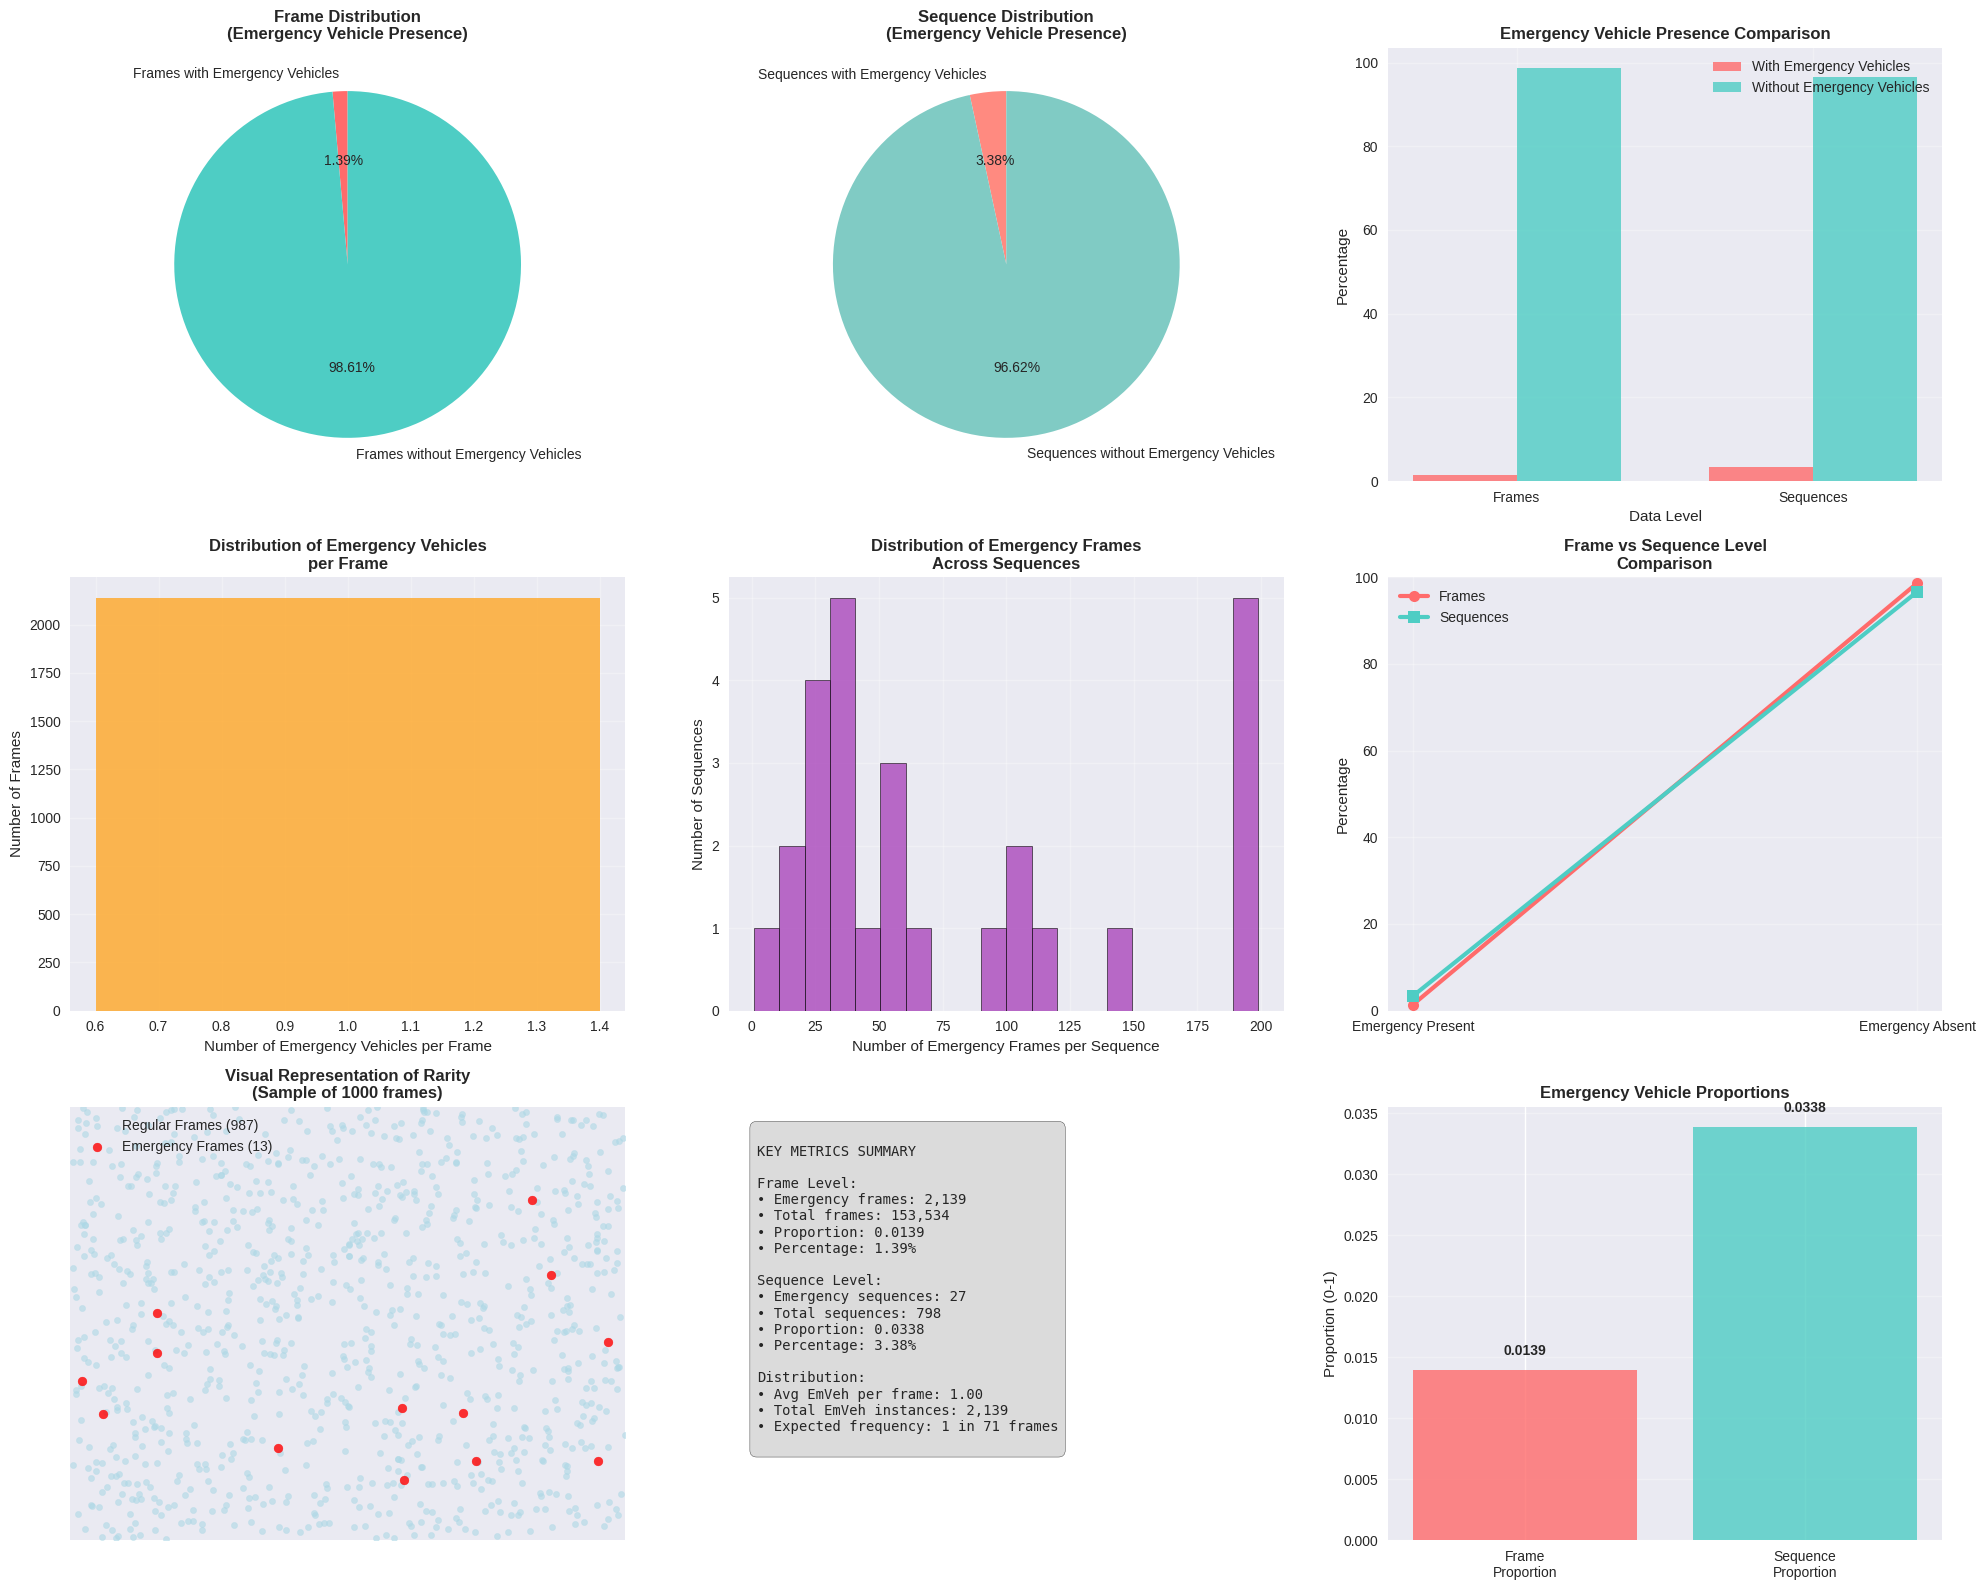

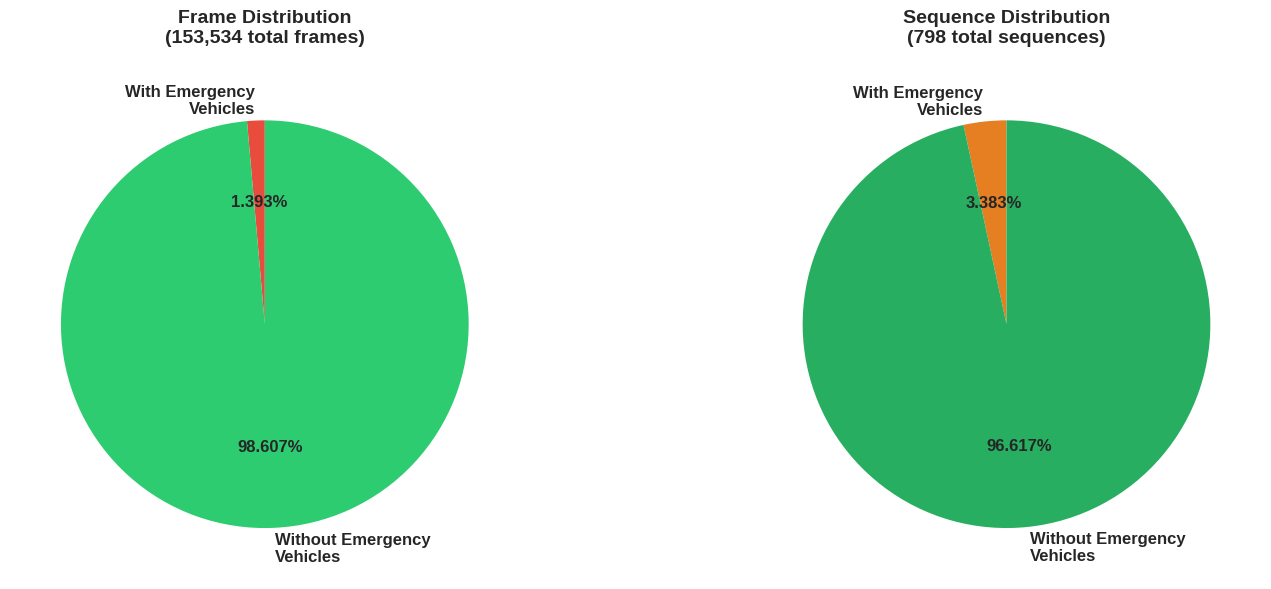

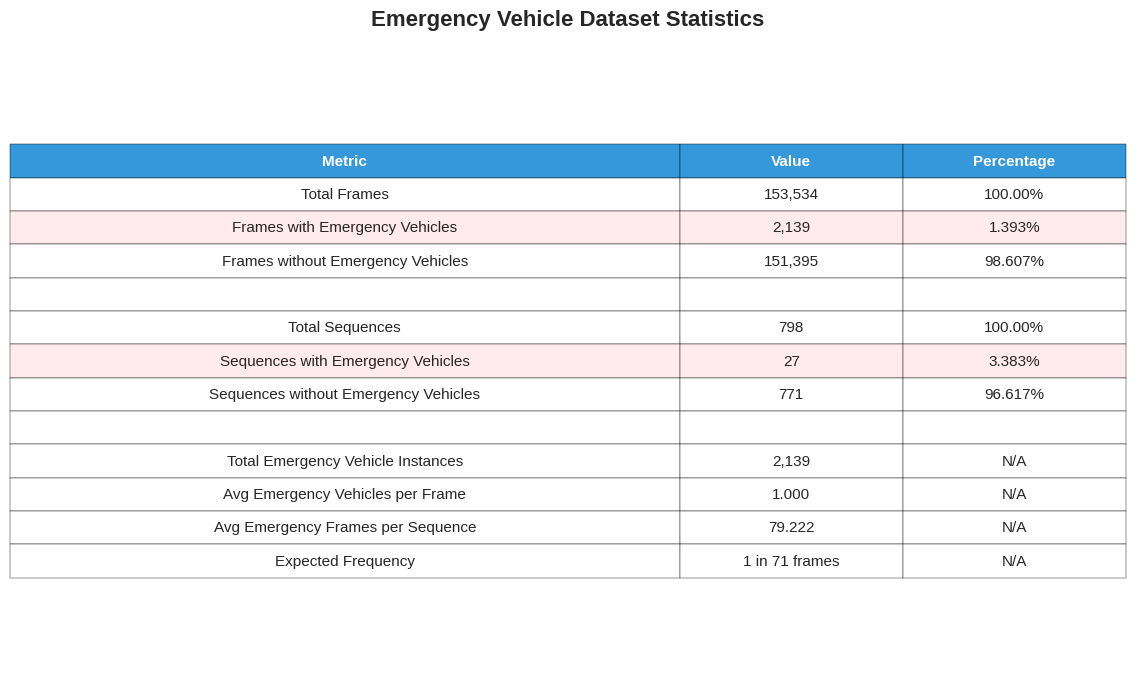


Creating sequence-frame visualization...


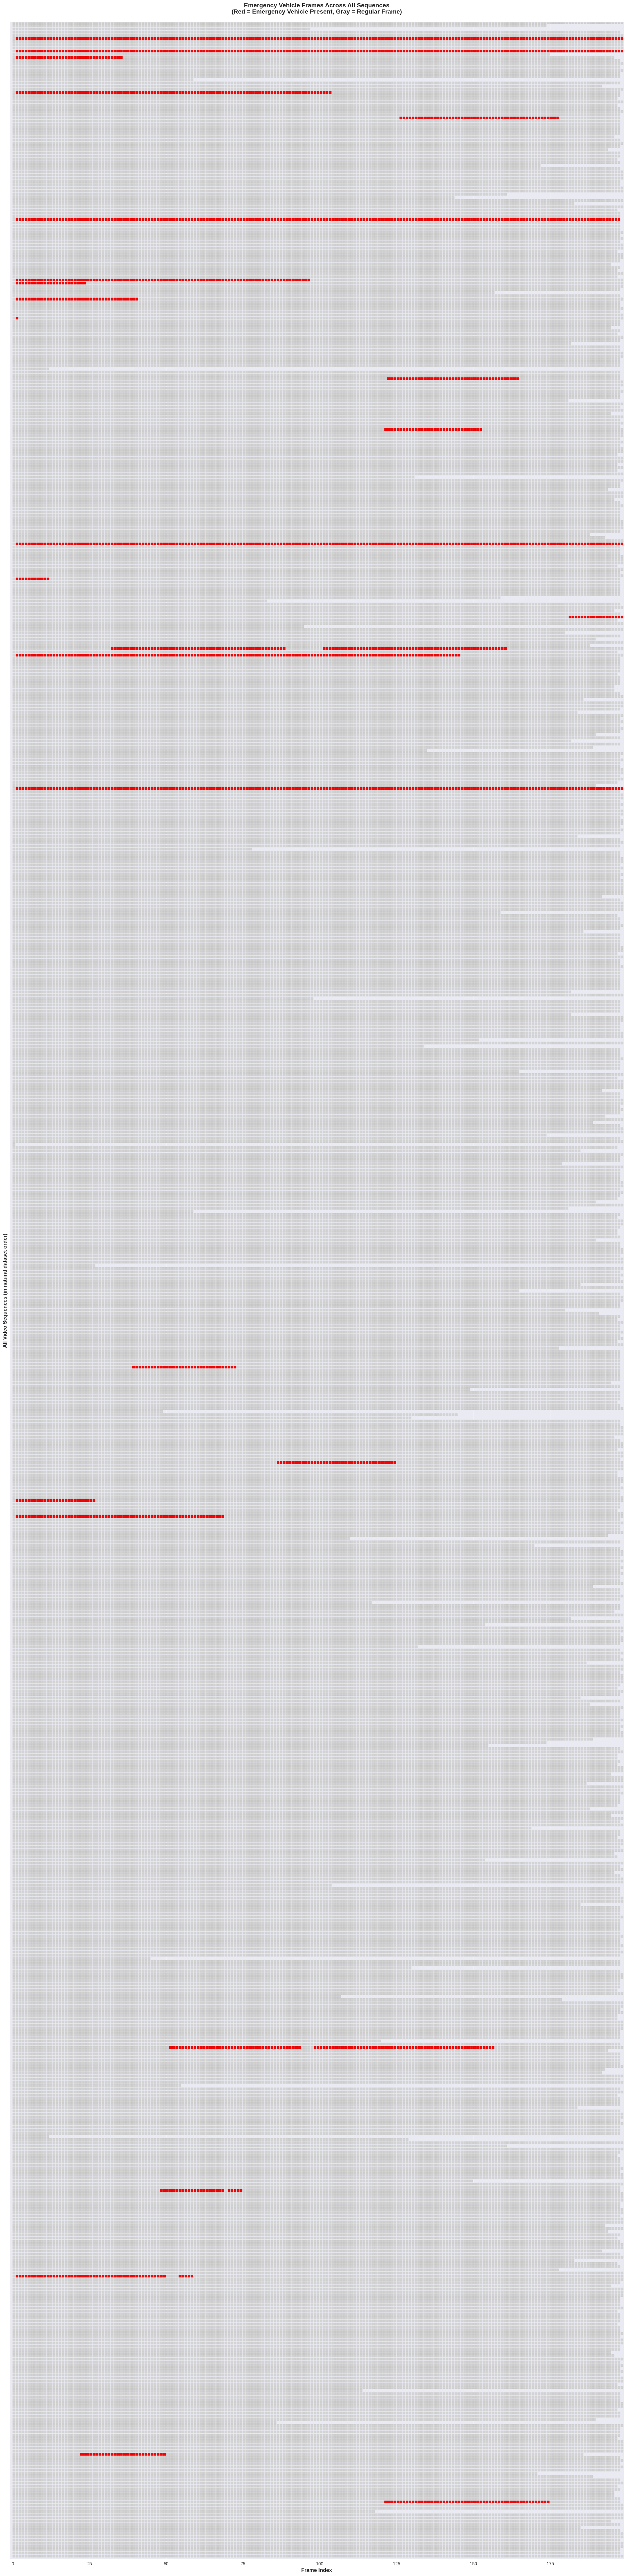

Sequence-frame visualization created showing all 798 sequences in natural dataset order (27 with emergency vehicles, 771 without)

Preparing YOLO dataset...
Split: 21 train sequences, 6 validation sequences


Processing val split: 100%|██████████| 6/6 [00:00<00:00, 68.80it/s]

Created YOLO dataset with 1469 training images and 670 validation images

YOLO dataset preparation complete!

Visualization files saved to: /content/waymo_emergency_vehicle_detection/visualizations
- emergency_vehicle_analysis.png (comprehensive overview)
- emergency_proportions_focus.png (clear proportion charts)
- emergency_statistics_table.png (detailed statistics table)
- emergency_frames_sequence_view.png (sequence-frame timeline visualization)


In [19]:
import os
import json
import cv2
import numpy as np
from tqdm import tqdm
import random
import shutil
from google.cloud import storage
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load the JSON data
with open('road_waymo_trainval_v1.0.json', 'r') as file:
    data = json.load(file)

# Define class indices for reference
agent_labels = data['agent_labels']
emveh_idx = agent_labels.index('EmVeh')
print(f"Emergency Vehicle class index: {emveh_idx}")

# Define directories
BASE_DIR = "/content/waymo_emergency_vehicle_detection"
FRAMES_DIR = os.path.join(BASE_DIR, "data/frames")
YOLO_DIR = os.path.join(BASE_DIR, "yolo_dataset")
VISUALIZATION_DIR = os.path.join(BASE_DIR, "visualizations")

# Create visualization directory
os.makedirs(VISUALIZATION_DIR, exist_ok=True)

# Define metadata to track statistics
dataset_stats = {
    'total_sequences': 0,
    'sequences_with_emergency': 0,
    'total_frames': 0,
    'frames_with_emergency': 0,
    'total_emergency_instances': 0,
    'emergency_frames_by_sequence': {},
    'emergency_instances_by_frame': defaultdict(int),
    'frames_by_sequence': {}
}

# Function to convert coordinates from [x_min, y_min, x_max, y_max] to YOLO [x_center, y_center, width, height]
def convert_to_yolo_format(box, img_width, img_height):
    # Assuming box is [x_min, y_min, x_max, y_max] in normalized coordinates
    x_min, y_min, x_max, y_max = box

    # Calculate center coordinates and dimensions (normalized)
    x_center = (x_min + x_max) / 2
    y_center = (y_min + y_max) / 2
    width = x_max - x_min
    height = y_max - y_min

    return [x_center, y_center, width, height]

# Function to explore all sequences in the dataset for emergency vehicles
def find_all_emergency_vehicles():
    """Find all frames containing emergency vehicles and collect statistics"""

    # Initialize collection of emergency vehicle annotations
    emergency_annotations = {}

    # Iterate through all sequences
    for sequence_id, sequence_data in tqdm(data['db'].items(), desc="Analyzing sequences"):
        dataset_stats['total_sequences'] += 1
        frames_in_seq = 0
        emergency_frames_in_seq = 0

        # Check if this sequence contains any frames
        if 'frames' not in sequence_data:
            continue

        # Get all frames in this sequence
        frames = sequence_data.get('frames', {})

        # Iterate through all frames
        for frame_id, frame_data in frames.items():
            dataset_stats['total_frames'] += 1
            frames_in_seq += 1

            # Get the annotations for this frame
            if 'annos' not in frame_data:
                continue

            annotations = frame_data['annos']

            # Look for emergency vehicles in the annotations
            emergency_instances = []

            for anno_id, anno_data in annotations.items():
                # Check if the annotation includes agent_ids
                if not isinstance(anno_data, dict) or 'agent_ids' not in anno_data:
                    continue

                # Check if agent_ids contains emergency vehicle index
                if emveh_idx in anno_data['agent_ids']:
                    # Found an emergency vehicle!
                    if 'box' in anno_data:
                        # Add this instance to our collection
                        emergency_instances.append({
                            'box': anno_data['box'],
                            'frame_id': frame_id,
                            'rgb_image_id': frame_data.get('rgb_image_id'),
                            'width': frame_data.get('width', 1920),
                            'height': frame_data.get('height', 1280)
                        })

            # If we found emergency vehicles in this frame, update statistics
            if emergency_instances:
                dataset_stats['frames_with_emergency'] += 1
                emergency_frames_in_seq += 1
                dataset_stats['total_emergency_instances'] += len(emergency_instances)

                # Track distribution of emergency vehicles per frame
                dataset_stats['emergency_instances_by_frame'][len(emergency_instances)] += 1

                # Store the annotations
                if sequence_id not in emergency_annotations:
                    emergency_annotations[sequence_id] = {}

                emergency_annotations[sequence_id][frame_id] = {
                    'instances': emergency_instances,
                    'rgb_image_id': frame_data.get('rgb_image_id'),
                    'width': frame_data.get('width', 1920),
                    'height': frame_data.get('height', 1280)
                }

        # Update statistics for this sequence
        dataset_stats['frames_by_sequence'][sequence_id] = frames_in_seq
        if emergency_frames_in_seq > 0:
            dataset_stats['sequences_with_emergency'] += 1
            dataset_stats['emergency_frames_by_sequence'][sequence_id] = emergency_frames_in_seq

    # Calculate proportions and percentages
    calculate_proportions()

    # Print comprehensive statistics
    print_comprehensive_stats()

    # Return the collected annotations
    return emergency_annotations

def calculate_proportions():
    """Calculate proportions and percentages for analysis"""
    total_frames = dataset_stats['total_frames']
    frames_with_emergency = dataset_stats['frames_with_emergency']
    total_sequences = dataset_stats['total_sequences']
    sequences_with_emergency = dataset_stats['sequences_with_emergency']

    # Frame-level proportions
    dataset_stats['frame_emergency_proportion'] = frames_with_emergency / total_frames if total_frames > 0 else 0
    dataset_stats['frame_emergency_percentage'] = dataset_stats['frame_emergency_proportion'] * 100
    dataset_stats['frames_without_emergency'] = total_frames - frames_with_emergency
    dataset_stats['frame_no_emergency_proportion'] = dataset_stats['frames_without_emergency'] / total_frames if total_frames > 0 else 0
    dataset_stats['frame_no_emergency_percentage'] = dataset_stats['frame_no_emergency_proportion'] * 100

    # Sequence-level proportions
    dataset_stats['sequence_emergency_proportion'] = sequences_with_emergency / total_sequences if total_sequences > 0 else 0
    dataset_stats['sequence_emergency_percentage'] = dataset_stats['sequence_emergency_proportion'] * 100
    dataset_stats['sequences_without_emergency'] = total_sequences - sequences_with_emergency
    dataset_stats['sequence_no_emergency_proportion'] = dataset_stats['sequences_without_emergency'] / total_sequences if total_sequences > 0 else 0
    dataset_stats['sequence_no_emergency_percentage'] = dataset_stats['sequence_no_emergency_proportion'] * 100

    # Average emergency vehicles per frame (considering only frames with emergency vehicles)
    dataset_stats['avg_emergency_per_frame'] = dataset_stats['total_emergency_instances'] / frames_with_emergency if frames_with_emergency > 0 else 0

    # Average emergency frames per sequence (considering only sequences with emergency vehicles)
    dataset_stats['avg_emergency_frames_per_sequence'] = frames_with_emergency / sequences_with_emergency if sequences_with_emergency > 0 else 0

def print_comprehensive_stats():
    """Print comprehensive statistics about emergency vehicle distribution"""
    print("\n" + "="*60)
    print("COMPREHENSIVE EMERGENCY VEHICLE ANALYSIS")
    print("="*60)

    print(f"\n📊 OVERALL DATASET STATISTICS:")
    print(f"   Total sequences: {dataset_stats['total_sequences']:,}")
    print(f"   Total frames: {dataset_stats['total_frames']:,}")
    print(f"   Total emergency vehicle instances: {dataset_stats['total_emergency_instances']:,}")

    print(f"\n🚨 FRAME-LEVEL ANALYSIS:")
    print(f"   Frames with emergency vehicles: {dataset_stats['frames_with_emergency']:,} ({dataset_stats['frame_emergency_percentage']:.2f}%)")
    print(f"   Frames without emergency vehicles: {dataset_stats['frames_without_emergency']:,} ({dataset_stats['frame_no_emergency_percentage']:.2f}%)")
    print(f"   Emergency vehicle frame proportion: {dataset_stats['frame_emergency_proportion']:.4f}")

    print(f"\n🎬 SEQUENCE-LEVEL ANALYSIS:")
    print(f"   Sequences with emergency vehicles: {dataset_stats['sequences_with_emergency']:,} ({dataset_stats['sequence_emergency_percentage']:.2f}%)")
    print(f"   Sequences without emergency vehicles: {dataset_stats['sequences_without_emergency']:,} ({dataset_stats['sequence_no_emergency_percentage']:.2f}%)")
    print(f"   Emergency vehicle sequence proportion: {dataset_stats['sequence_emergency_proportion']:.4f}")

    print(f"\n📈 DISTRIBUTION METRICS:")
    print(f"   Average emergency vehicles per frame (when present): {dataset_stats['avg_emergency_per_frame']:.2f}")
    print(f"   Average emergency frames per sequence (when present): {dataset_stats['avg_emergency_frames_per_sequence']:.2f}")

    print(f"\n🔢 RARITY ANALYSIS:")
    if dataset_stats['frame_emergency_proportion'] < 0.01:
        rarity = "extremely rare"
    elif dataset_stats['frame_emergency_proportion'] < 0.05:
        rarity = "very rare"
    elif dataset_stats['frame_emergency_proportion'] < 0.1:
        rarity = "rare"
    elif dataset_stats['frame_emergency_proportion'] < 0.2:
        rarity = "uncommon"
    else:
        rarity = "common"

    print(f"   Emergency vehicles are {rarity} in this dataset")
    print(f"   You would expect to see an emergency vehicle roughly 1 in every {int(1/dataset_stats['frame_emergency_proportion'])} frames")

def create_sequence_frame_visualization(emergency_annotations):
    """Create visualization showing emergency vehicle frames across sequences like illuminated pages in stacked books"""

    # Get all sequences in their natural order from the dataset
    all_sequences = list(dataset_stats['frames_by_sequence'].keys())

    # Use all sequences, no limiting
    top_sequences = all_sequences
    num_sequences = len(top_sequences)

    # Create figure with dynamic height based on number of sequences
    fig, ax = plt.subplots(figsize=(20, num_sequences * 0.1 + 2))

    # Create matrix for visualization
    max_frames = max([dataset_stats['frames_by_sequence'].get(seq_id, 0) for seq_id in top_sequences])

    for i, seq_id in enumerate(top_sequences):
        total_frames = dataset_stats['frames_by_sequence'].get(seq_id, 0)
        emergency_frames = emergency_annotations.get(seq_id, {})

        # Create row for this sequence
        y_pos = num_sequences - i - 1

        # Draw all frames as gray bars (books)
        for frame_idx in range(total_frames):
            if frame_idx < max_frames:  # Limit display width
                ax.add_patch(plt.Rectangle((frame_idx, y_pos), 0.8, 0.8,
                                         facecolor='lightgray', edgecolor='gray', linewidth=0.1))

        # Highlight emergency vehicle frames in red (illuminated pages) if any exist
        if emergency_frames:
            for frame_id in emergency_frames.keys():
                frame_idx = int(frame_id) if isinstance(frame_id, str) and frame_id.isdigit() else hash(frame_id) % total_frames
                if frame_idx < max_frames:
                    ax.add_patch(plt.Rectangle((frame_idx, y_pos), 0.8, 0.8,
                                             facecolor='red', edgecolor='darkred', linewidth=0.2))

    # Set limits and labels
    ax.set_xlim(-1, min(max_frames, 200))  # Limit x-axis for readability
    ax.set_ylim(-0.5, num_sequences - 0.5)

    # Customize plot
    ax.set_xlabel('Frame Index', fontsize=12, fontweight='bold')
    ax.set_ylabel('All Video Sequences (in natural dataset order)', fontsize=12, fontweight='bold')
    ax.set_title('Emergency Vehicle Frames Across All Sequences\n(Red = Emergency Vehicle Present, Gray = Regular Frame)',
                 fontsize=14, fontweight='bold', pad=20)

    # Add legend
    from matplotlib.patches import Patch

    # Remove y-ticks for cleaner look
    ax.set_yticks([])

    # Add grid for better readability
    ax.grid(True, alpha=0.3, axis='x')

    plt.tight_layout()
    plt.savefig(os.path.join(VISUALIZATION_DIR, 'emergency_frames_sequence_view.png'),
                dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

    print(f"Sequence-frame visualization created showing all {num_sequences} sequences in natural dataset order ({len([s for s in top_sequences if s in emergency_annotations])} with emergency vehicles, {len([s for s in top_sequences if s not in emergency_annotations])} without)")

def create_visualizations():
    """Create comprehensive visualizations of emergency vehicle distribution"""

    # Set up the figure with subplots
    fig = plt.figure(figsize=(20, 16))

    # 1. Frame-level pie chart
    plt.subplot(3, 3, 1)
    frame_labels = ['Frames with Emergency Vehicles', 'Frames without Emergency Vehicles']
    frame_sizes = [dataset_stats['frames_with_emergency'], dataset_stats['frames_without_emergency']]
    frame_colors = ['#ff6b6b', '#4ecdc4']

    plt.pie(frame_sizes, labels=frame_labels, autopct='%1.2f%%', colors=frame_colors, startangle=90)
    plt.title('Frame Distribution\n(Emergency Vehicle Presence)', fontsize=12, fontweight='bold')

    # 2. Sequence-level pie chart
    plt.subplot(3, 3, 2)
    seq_labels = ['Sequences with Emergency Vehicles', 'Sequences without Emergency Vehicles']
    seq_sizes = [dataset_stats['sequences_with_emergency'], dataset_stats['sequences_without_emergency']]
    seq_colors = ['#ff8a80', '#80cbc4']

    plt.pie(seq_sizes, labels=seq_labels, autopct='%1.2f%%', colors=seq_colors, startangle=90)
    plt.title('Sequence Distribution\n(Emergency Vehicle Presence)', fontsize=12, fontweight='bold')

    # 3. Bar chart comparison
    plt.subplot(3, 3, 3)
    categories = ['Frames', 'Sequences']
    with_emergency = [dataset_stats['frame_emergency_percentage'], dataset_stats['sequence_emergency_percentage']]
    without_emergency = [dataset_stats['frame_no_emergency_percentage'], dataset_stats['sequence_no_emergency_percentage']]

    x = np.arange(len(categories))
    width = 0.35

    plt.bar(x - width/2, with_emergency, width, label='With Emergency Vehicles', color='#ff6b6b', alpha=0.8)
    plt.bar(x + width/2, without_emergency, width, label='Without Emergency Vehicles', color='#4ecdc4', alpha=0.8)

    plt.xlabel('Data Level')
    plt.ylabel('Percentage')
    plt.title('Emergency Vehicle Presence Comparison', fontweight='bold')
    plt.xticks(x, categories)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 4. Distribution of emergency vehicles per frame
    plt.subplot(3, 3, 4)
    if dataset_stats['emergency_instances_by_frame']:
        instances_counts = list(dataset_stats['emergency_instances_by_frame'].keys())
        instances_frequencies = list(dataset_stats['emergency_instances_by_frame'].values())

        plt.bar(instances_counts, instances_frequencies, color='#ffa726', alpha=0.8)
        plt.xlabel('Number of Emergency Vehicles per Frame')
        plt.ylabel('Number of Frames')
        plt.title('Distribution of Emergency Vehicles\nper Frame', fontweight='bold')
        plt.grid(True, alpha=0.3)

    # 5. Emergency frames distribution across sequences
    plt.subplot(3, 3, 5)
    if dataset_stats['emergency_frames_by_sequence']:
        emergency_frame_counts = list(dataset_stats['emergency_frames_by_sequence'].values())
        plt.hist(emergency_frame_counts, bins=min(20, len(set(emergency_frame_counts))),
                color='#ab47bc', alpha=0.8, edgecolor='black', linewidth=0.5)
        plt.xlabel('Number of Emergency Frames per Sequence')
        plt.ylabel('Number of Sequences')
        plt.title('Distribution of Emergency Frames\nAcross Sequences', fontweight='bold')
        plt.grid(True, alpha=0.3)

    # 6. Cumulative percentage chart
    plt.subplot(3, 3, 6)
    frame_proportions = [dataset_stats['frame_emergency_percentage'], dataset_stats['frame_no_emergency_percentage']]
    seq_proportions = [dataset_stats['sequence_emergency_percentage'], dataset_stats['sequence_no_emergency_percentage']]

    categories = ['Emergency Present', 'Emergency Absent']

    plt.plot(categories, frame_proportions, 'o-', linewidth=3, markersize=8, label='Frames', color='#ff6b6b')
    plt.plot(categories, seq_proportions, 's-', linewidth=3, markersize=8, label='Sequences', color='#4ecdc4')

    plt.ylabel('Percentage')
    plt.title('Frame vs Sequence Level\nComparison', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 100)

    # 7. Rarity visualization
    plt.subplot(3, 3, 7)
    total_frames = dataset_stats['total_frames']
    emergency_frames = dataset_stats['frames_with_emergency']

    # Create a visual representation of rarity
    sample_size = min(1000, total_frames)  # Sample for visualization
    emergency_sample = int((emergency_frames / total_frames) * sample_size)
    regular_sample = sample_size - emergency_sample

    # Create a scatter plot representation
    np.random.seed(42)  # For reproducible visualization
    x_emergency = np.random.uniform(0, 10, emergency_sample)
    y_emergency = np.random.uniform(0, 10, emergency_sample)
    x_regular = np.random.uniform(0, 10, regular_sample)
    y_regular = np.random.uniform(0, 10, regular_sample)

    plt.scatter(x_regular, y_regular, c='lightblue', alpha=0.6, s=20, label=f'Regular Frames ({regular_sample})')
    plt.scatter(x_emergency, y_emergency, c='red', alpha=0.8, s=40, label=f'Emergency Frames ({emergency_sample})')

    plt.xlim(0, 10)
    plt.ylim(0, 10)
    plt.title(f'Visual Representation of Rarity\n(Sample of {sample_size} frames)', fontweight='bold')
    plt.legend()
    plt.xticks([])
    plt.yticks([])

    # 8. Key metrics summary
    plt.subplot(3, 3, 8)
    plt.axis('off')

    metrics_text = f"""
KEY METRICS SUMMARY

Frame Level:
• Emergency frames: {dataset_stats['frames_with_emergency']:,}
• Total frames: {dataset_stats['total_frames']:,}
• Proportion: {dataset_stats['frame_emergency_proportion']:.4f}
• Percentage: {dataset_stats['frame_emergency_percentage']:.2f}%

Sequence Level:
• Emergency sequences: {dataset_stats['sequences_with_emergency']:,}
• Total sequences: {dataset_stats['total_sequences']:,}
• Proportion: {dataset_stats['sequence_emergency_proportion']:.4f}
• Percentage: {dataset_stats['sequence_emergency_percentage']:.2f}%

Distribution:
• Avg EmVeh per frame: {dataset_stats['avg_emergency_per_frame']:.2f}
• Total EmVeh instances: {dataset_stats['total_emergency_instances']:,}
• Expected frequency: 1 in {int(1/dataset_stats['frame_emergency_proportion']) if dataset_stats['frame_emergency_proportion'] > 0 else 'N/A'} frames
"""

    plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))

    # 9. Proportion comparison chart
    plt.subplot(3, 3, 9)
    proportions = [
        dataset_stats['frame_emergency_proportion'],
        dataset_stats['sequence_emergency_proportion']
    ]
    labels = ['Frame\nProportion', 'Sequence\nProportion']
    colors = ['#ff6b6b', '#4ecdc4']

    bars = plt.bar(labels, proportions, color=colors, alpha=0.8)
    plt.ylabel('Proportion (0-1)')
    plt.title('Emergency Vehicle Proportions', fontweight='bold')
    plt.grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for bar, prop in zip(bars, proportions):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{prop:.4f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()

    # Save the comprehensive visualization
    plt.savefig(os.path.join(VISUALIZATION_DIR, 'emergency_vehicle_analysis.png'),
                dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

    # Create additional focused visualizations
    create_focused_visualizations()

def create_focused_visualizations():
    """Create additional focused visualizations"""

    # 1. Large, clear proportion visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Frame proportion
    ax1.pie([dataset_stats['frames_with_emergency'], dataset_stats['frames_without_emergency']],
            labels=['With Emergency\nVehicles', 'Without Emergency\nVehicles'],
            autopct='%1.3f%%',
            colors=['#e74c3c', '#2ecc71'],
            startangle=90,
            textprops={'fontsize': 12, 'fontweight': 'bold'})
    ax1.set_title(f'Frame Distribution\n({dataset_stats["total_frames"]:,} total frames)',
                  fontsize=14, fontweight='bold', pad=20)

    # Sequence proportion
    ax2.pie([dataset_stats['sequences_with_emergency'], dataset_stats['sequences_without_emergency']],
            labels=['With Emergency\nVehicles', 'Without Emergency\nVehicles'],
            autopct='%1.3f%%',
            colors=['#e67e22', '#27ae60'],
            startangle=90,
            textprops={'fontsize': 12, 'fontweight': 'bold'})
    ax2.set_title(f'Sequence Distribution\n({dataset_stats["total_sequences"]:,} total sequences)',
                  fontsize=14, fontweight='bold', pad=20)

    plt.tight_layout()
    plt.savefig(os.path.join(VISUALIZATION_DIR, 'emergency_proportions_focus.png'),
                dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

    # 2. Detailed statistics table as an image
    create_statistics_table()

def create_statistics_table():
    """Create a detailed statistics table as a visualization"""
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.axis('tight')
    ax.axis('off')

    # Prepare table data
    table_data = [
        ['Metric', 'Value', 'Percentage'],
        ['Total Frames', f"{dataset_stats['total_frames']:,}", '100.00%'],
        ['Frames with Emergency Vehicles', f"{dataset_stats['frames_with_emergency']:,}", f"{dataset_stats['frame_emergency_percentage']:.3f}%"],
        ['Frames without Emergency Vehicles', f"{dataset_stats['frames_without_emergency']:,}", f"{dataset_stats['frame_no_emergency_percentage']:.3f}%"],
        ['', '', ''],
        ['Total Sequences', f"{dataset_stats['total_sequences']:,}", '100.00%'],
        ['Sequences with Emergency Vehicles', f"{dataset_stats['sequences_with_emergency']:,}", f"{dataset_stats['sequence_emergency_percentage']:.3f}%"],
        ['Sequences without Emergency Vehicles', f"{dataset_stats['sequences_without_emergency']:,}", f"{dataset_stats['sequence_no_emergency_percentage']:.3f}%"],
        ['', '', ''],
        ['Total Emergency Vehicle Instances', f"{dataset_stats['total_emergency_instances']:,}", 'N/A'],
        ['Avg Emergency Vehicles per Frame', f"{dataset_stats['avg_emergency_per_frame']:.3f}", 'N/A'],
        ['Avg Emergency Frames per Sequence', f"{dataset_stats['avg_emergency_frames_per_sequence']:.3f}", 'N/A'],
        ['Expected Frequency', f"1 in {int(1/dataset_stats['frame_emergency_proportion']) if dataset_stats['frame_emergency_proportion'] > 0 else 'N/A'} frames", 'N/A']
    ]

    # Create table
    table = ax.table(cellText=table_data[1:], colLabels=table_data[0],
                    cellLoc='center', loc='center',
                    colWidths=[0.6, 0.2, 0.2])

    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1.2, 2)

    # Color header row
    for i in range(len(table_data[0])):
        table[(0, i)].set_facecolor('#3498db')
        table[(0, i)].set_text_props(weight='bold', color='white')

    # Color emergency vehicle rows
    for i in [2, 6]:  # Rows with emergency vehicle data
        for j in range(len(table_data[0])):
            table[(i, j)].set_facecolor('#ffebee')

    plt.title('Emergency Vehicle Dataset Statistics', fontsize=16, fontweight='bold', pad=20)
    plt.savefig(os.path.join(VISUALIZATION_DIR, 'emergency_statistics_table.png'),
                dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

# Function to prepare YOLO dataset (keeping original functionality)
def prepare_yolo_dataset(emergency_annotations, split_ratio=0.8):
    """
    Prepare the YOLO dataset from the annotations

    Args:
        emergency_annotations: Dictionary of annotations by sequence and frame
        split_ratio: Train/val split ratio (default: 0.8)
    """
    # Get all sequence IDs with emergency vehicles
    sequence_ids = list(emergency_annotations.keys())

    # Shuffle and split into train/val
    random.shuffle(sequence_ids)
    split_idx = int(len(sequence_ids) * split_ratio)
    train_sequences = sequence_ids[:split_idx]
    val_sequences = sequence_ids[split_idx:]

    print(f"Split: {len(train_sequences)} train sequences, {len(val_sequences)} validation sequences")

    # Create an image mapping file to document where the source images should be
    image_mapping = {
        'train': {},
        'val': {}
    }

    # Function to process annotations for a split
    def process_split(split_name, sequence_ids):
        count = 0

        for sequence_id in tqdm(sequence_ids, desc=f"Processing {split_name} split"):
            for frame_id, frame_data in emergency_annotations[sequence_id].items():
                rgb_image_id = frame_data['rgb_image_id']
                width = frame_data['width']
                height = frame_data['height']

                # Generate a unique output filename
                output_name = f"{sequence_id}_{frame_id}"

                # Record the image mapping
                image_mapping[split_name][output_name] = {
                    'sequence_id': sequence_id,
                    'frame_id': frame_id,
                    'rgb_image_id': rgb_image_id
                }

                # Create YOLO annotation file
                os.makedirs(os.path.join(YOLO_DIR, split_name, 'labels'), exist_ok=True)
                with open(os.path.join(YOLO_DIR, split_name, 'labels', f"{output_name}.txt"), 'w') as f:
                    for instance in frame_data['instances']:
                        box = instance['box']

                        # Convert box to YOLO format: class_id x_center y_center width height
                        yolo_box = convert_to_yolo_format(box, width, height)

                        # Write the annotation
                        f.write(f"0 {yolo_box[0]} {yolo_box[1]} {yolo_box[2]} {yolo_box[3]}\n")

                # Create a placeholder image file for now
                os.makedirs(os.path.join(YOLO_DIR, split_name, 'images'), exist_ok=True)
                placeholder_path = os.path.join(YOLO_DIR, split_name, 'images', f"{output_name}.jpg")
                with open(placeholder_path, 'w') as f:
                    f.write(f"Placeholder for {sequence_id}, frame {frame_id}, rgb_image_id {rgb_image_id}")

                count += 1

        return count

    # Process train and validation splits
    train_count = process_split('train', train_sequences)
    val_count = process_split('val', val_sequences)

    print(f"Created YOLO dataset with {train_count} training images and {val_count} validation images")

    # Save the image mapping for future reference
    with open(os.path.join(BASE_DIR, 'image_mapping.json'), 'w') as f:
        json.dump(image_mapping, f, indent=2)

    return image_mapping

# Function to attempt to download images from Waymo bucket (keeping original functionality)
def attempt_to_download_images(image_mapping):
    """
    Attempts to download images from Waymo bucket based on rgb_image_id
    This is a starting point and may need modification
    """
    # Initialize GCP client
    client = storage.Client()
    bucket_name = "waymo_open_dataset_road_plus_plus"
    bucket = client.bucket(bucket_name)

    # Try different possible path formats
    possible_path_formats = [
        # Format 1: direct ID
        "{rgb_image_id}.jpg",
        # Format 2: sequence folder
        "{sequence_id}/{rgb_image_id}.jpg",
        # Format 3: frames folder
        "frames/{sequence_id}/{rgb_image_id}.jpg",
        # Format 4: images folder
        "images/{sequence_id}/{rgb_image_id}.jpg",
        # Format 5: sequence_frame format
        "{sequence_id}_{frame_id}.jpg"
    ]

    # Try to download a sample of images
    sample_count = min(10, sum(len(seq_frames) for seq_frames in image_mapping['train'].values()) +
                          sum(len(seq_frames) for seq_frames in image_mapping['val'].values()))

    downloaded = 0

    print(f"Attempting to download {sample_count} sample images...")

    # Flatten the image mapping for sampling
    all_images = []
    for split in ['train', 'val']:
        for output_name, image_info in image_mapping[split].items():
            all_images.append((split, output_name, image_info))

    # Sample a subset
    sample_images = random.sample(all_images, min(sample_count, len(all_images)))

    for split, output_name, image_info in sample_images:
        # Try each possible path format
        for path_format in possible_path_formats:
            try:
                remote_path = path_format.format(
                    sequence_id=image_info['sequence_id'],
                    frame_id=image_info['frame_id'],
                    rgb_image_id=image_info['rgb_image_id']
                )

                local_path = os.path.join(YOLO_DIR, split, 'images', f"{output_name}.jpg")

                print(f"Trying to download {remote_path}...")

                blob = bucket.blob(remote_path)
                if blob.exists():
                    blob.download_to_filename(local_path)
                    print(f"Downloaded {remote_path} to {local_path}")
                    downloaded += 1
                    break
            except Exception as e:
                print(f"Error trying {path_format}: {e}")

    print(f"Downloaded {downloaded} out of {sample_count} attempted images")

    # If no images were downloaded, we need to explore the bucket structure more
    if downloaded == 0:
        print("Could not download any images. Exploring bucket structure...")

        # List blobs to understand structure
        # This will list the first 1000 blobs
        blobs = list(bucket.list_blobs(max_results=1000))

        if blobs:
            print("Sample blob names:")
            for i, blob in enumerate(blobs[:20]):
                print(f"  {i+1}. {blob.name}")
        else:
            print("No blobs found in the bucket. Check permissions and bucket name.")

    return downloaded

# Main execution
if __name__ == "__main__":
    # Create necessary directories
    os.makedirs(BASE_DIR, exist_ok=True)
    os.makedirs(YOLO_DIR, exist_ok=True)

    # Find all emergency vehicle instances
    print("Searching for emergency vehicles in the dataset...")
    emergency_annotations = find_all_emergency_vehicles()

    # Create comprehensive visualizations
    print("\nCreating visualizations...")
    create_visualizations()

    # Create the new sequence-frame visualization
    if emergency_annotations:
        print("\nCreating sequence-frame visualization...")
        create_sequence_frame_visualization(emergency_annotations)

    # Save the annotations for reference
    with open(os.path.join(BASE_DIR, 'emergency_annotations.json'), 'w') as f:
        json.dump(emergency_annotations, f, indent=2)

    # Save detailed statistics
    with open(os.path.join(BASE_DIR, 'dataset_statistics.json'), 'w') as f:
        json.dump(dataset_stats, f, indent=2)

    # Prepare the YOLO dataset
    if emergency_annotations:
        print("\nPreparing YOLO dataset...")
        image_mapping = prepare_yolo_dataset(emergency_annotations)

        print("\nYOLO dataset preparation complete!")
        print(f"\nVisualization files saved to: {VISUALIZATION_DIR}")
        print("- emergency_vehicle_analysis.png (comprehensive overview)")
        print("- emergency_proportions_focus.png (clear proportion charts)")
        print("- emergency_statistics_table.png (detailed statistics table)")
        print("- emergency_frames_sequence_view.png (sequence-frame timeline visualization)")

    else:
        print("No emergency vehicle instances found in the dataset.")

In [12]:
import os
import json
import cv2
import numpy as np
from tqdm import tqdm
import random
from google.cloud import storage

# Load our previously generated mappings
with open('/content/waymo_emergency_vehicle_detection/image_mapping.json', 'r') as f:
    image_mapping = json.load(f)

# Define directories
BASE_DIR = "/content/waymo_emergency_vehicle_detection"
VIDEOS_DIR = os.path.join(BASE_DIR, "data/videos")
FRAMES_DIR = os.path.join(BASE_DIR, "data/frames")
YOLO_DIR = os.path.join(BASE_DIR, "yolo_dataset")

# Make sure directories exist
os.makedirs(VIDEOS_DIR, exist_ok=True)
os.makedirs(FRAMES_DIR, exist_ok=True)

# Function to download videos from the bucket
def download_videos():
    """Download the required videos from the Waymo bucket"""

    # Initialize GCP client
    client = storage.Client()
    bucket_name = "waymo_open_dataset_road_plus_plus"
    bucket = client.bucket(bucket_name)

    # Gather unique sequence IDs from our annotations
    sequence_ids = set()
    for split in ['train', 'val']:
        for output_name, image_info in image_mapping[split].items():
            sequence_id = image_info['sequence_id']
            sequence_ids.add(sequence_id)

    print(f"Need to download {len(sequence_ids)} video sequences")

    # Try different possible video path formats
    possible_path_formats = [
        "videos/{sequence_id}.mp4",
        "test_videos/{sequence_id}.mp4",
        "train_videos/{sequence_id}.mp4",
        "{sequence_id}.mp4"
    ]

    # Download each video
    downloaded = 0
    for sequence_id in tqdm(sequence_ids, desc="Downloading videos"):
        # Check if already downloaded
        local_video_path = os.path.join(VIDEOS_DIR, f"{sequence_id}.mp4")
        if os.path.exists(local_video_path):
            print(f"Video {sequence_id}.mp4 already exists, skipping...")
            downloaded += 1
            continue

        # Try each possible path format
        for path_format in possible_path_formats:
            try:
                remote_path = path_format.format(sequence_id=sequence_id)

                print(f"Trying to download {remote_path}...")

                blob = bucket.blob(remote_path)
                if blob.exists():
                    blob.download_to_filename(local_video_path)
                    print(f"Downloaded {remote_path} to {local_video_path}")
                    downloaded += 1
                    break
            except Exception as e:
                print(f"Error trying {path_format}: {e}")

    print(f"Downloaded {downloaded} out of {len(sequence_ids)} required videos")

    # If couldn't download, try listing the bucket to find video paths
    if downloaded < len(sequence_ids):
        print("Could not download all required videos. Exploring bucket structure...")

        # List blobs to find video files
        print("Searching for video files in the bucket...")
        blobs = [b for b in bucket.list_blobs() if b.name.endswith('.mp4')]

        if blobs:
            print(f"Found {len(blobs)} video files in the bucket:")
            for i, blob in enumerate(sorted(b.name for b in blobs)[:20]):
                print(f"  {i+1}. {blob}")

            # Try to map sequence IDs to blob names
            for sequence_id in list(sequence_ids):
                # If already downloaded, skip
                if os.path.exists(os.path.join(VIDEOS_DIR, f"{sequence_id}.mp4")):
                    continue

                # Try to find a matching blob
                matching_blobs = [b for b in blobs if sequence_id in b.name]
                if matching_blobs:
                    blob = matching_blobs[0]
                    local_path = os.path.join(VIDEOS_DIR, f"{sequence_id}.mp4")
                    try:
                        print(f"Downloading {blob.name} to {local_path}...")
                        blob.download_to_filename(local_path)
                        downloaded += 1
                    except Exception as e:
                        print(f"Error downloading {blob.name}: {e}")
        else:
            print("No video files found in the bucket.")

    return downloaded

# Function to extract frames from videos
def extract_frames():
    """Extract frames from videos based on our annotations"""

    frames_extracted = 0
    failed_extractions = 0

    # Process each split
    for split in ['train', 'val']:
        # Group by sequence_id for efficiency
        by_sequence = {}
        for output_name, image_info in image_mapping[split].items():
            sequence_id = image_info['sequence_id']
            if sequence_id not in by_sequence:
                by_sequence[sequence_id] = []
            by_sequence[sequence_id].append((output_name, image_info))

        # Process each sequence
        for sequence_id, entries in tqdm(by_sequence.items(), desc=f"Extracting {split} frames"):
            video_path = os.path.join(VIDEOS_DIR, f"{sequence_id}.mp4")

            # Check if video exists
            if not os.path.exists(video_path):
                print(f"Video file {video_path} not found, skipping {len(entries)} frames")
                failed_extractions += len(entries)
                continue

            try:
                # Open the video file
                cap = cv2.VideoCapture(video_path)
                if not cap.isOpened():
                    print(f"Could not open video file {video_path}")
                    failed_extractions += len(entries)
                    continue

                # Get video properties
                fps = cap.get(cv2.CAP_PROP_FPS)
                frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

                print(f"Video {sequence_id}.mp4: {frame_count} frames at {fps} fps")

                # Extract each frame
                for output_name, image_info in entries:
                    frame_id = image_info['frame_id']
                    frame_index = int(frame_id) - 1  # Convert to 0-based index

                    # Set the frame position
                    if frame_index >= frame_count:
                        print(f"Frame index {frame_index} exceeds video length {frame_count}")
                        failed_extractions += 1
                        continue

                    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)

                    # Read the frame
                    ret, frame = cap.read()
                    if not ret:
                        print(f"Could not read frame {frame_id} from video {sequence_id}")
                        failed_extractions += 1
                        continue

                    # Save the frame
                    frame_path = os.path.join(YOLO_DIR, split, 'images', f"{output_name}.jpg")
                    cv2.imwrite(frame_path, frame)

                    frames_extracted += 1

                # Release the video
                cap.release()

            except Exception as e:
                print(f"Error processing video {sequence_id}: {e}")
                failed_extractions += len(entries)

    print(f"Extracted {frames_extracted} frames, failed to extract {failed_extractions} frames")
    return frames_extracted

# Function to verify YOLO dataset
def verify_yolo_dataset():
    """Verify that the YOLO dataset is correctly set up"""

    # Check train and val splits
    dataset_stats = {
        'train_images': 0,
        'train_labels': 0,
        'val_images': 0,
        'val_labels': 0,
        'missing_images': 0,
        'missing_labels': 0
    }

    for split in ['train', 'val']:
        images_dir = os.path.join(YOLO_DIR, split, 'images')
        labels_dir = os.path.join(YOLO_DIR, split, 'labels')

        # Count image and label files
        image_files = set(f for f in os.listdir(images_dir) if f.endswith('.jpg'))
        label_files = set(f for f in os.listdir(labels_dir) if f.endswith('.txt'))

        # Convert label extensions for comparison
        label_bases = set(os.path.splitext(f)[0] for f in label_files)
        image_bases = set(os.path.splitext(f)[0] for f in image_files)

        # Calculate statistics
        dataset_stats[f'{split}_images'] = len(image_files)
        dataset_stats[f'{split}_labels'] = len(label_files)

        # Check for mismatches
        missing_images = label_bases - image_bases
        missing_labels = image_bases - label_bases

        if missing_images:
            print(f"WARNING: {len(missing_images)} labels in {split} set have no corresponding images")
            dataset_stats['missing_images'] += len(missing_images)

        if missing_labels:
            print(f"WARNING: {len(missing_labels)} images in {split} set have no corresponding labels")
            dataset_stats['missing_labels'] += len(missing_labels)

    # Print summary
    print("\nYOLO Dataset Verification:")
    print(f"Training set: {dataset_stats['train_images']} images, {dataset_stats['train_labels']} labels")
    print(f"Validation set: {dataset_stats['val_images']} images, {dataset_stats['val_labels']} labels")
    print(f"Missing images: {dataset_stats['missing_images']}")
    print(f"Missing labels: {dataset_stats['missing_labels']}")

    # Create a simple visualization of some annotated images
    print("\nCreating sample visualizations...")
    visualize_samples(3, 'train')
    visualize_samples(3, 'val')

# Function to visualize sample images with annotations
def visualize_samples(num_samples, split):
    """Visualize sample images with bounding boxes for verification"""

    images_dir = os.path.join(YOLO_DIR, split, 'images')
    labels_dir = os.path.join(YOLO_DIR, split, 'labels')

    # Get image files with corresponding labels
    image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg') and
                   os.path.exists(os.path.join(labels_dir, f.replace('.jpg', '.txt')))]

    if not image_files:
        print(f"No suitable images found for visualization in {split} set")
        return

    # Select random samples
    samples = random.sample(image_files, min(num_samples, len(image_files)))

    for image_file in samples:
        # Load image
        image_path = os.path.join(images_dir, image_file)
        img = cv2.imread(image_path)
        if img is None:
            print(f"Could not load image {image_path}")
            continue

        # Get dimensions
        height, width, _ = img.shape

        # Load annotations
        label_path = os.path.join(labels_dir, image_file.replace('.jpg', '.txt'))

        # Draw bounding boxes
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    class_id, x_center, y_center, box_width, box_height = map(float, parts)

                    # Convert YOLO format to pixel coordinates
                    x_center *= width
                    y_center *= height
                    box_width *= width
                    box_height *= height

                    x1 = int(x_center - box_width / 2)
                    y1 = int(y_center - box_height / 2)
                    x2 = int(x_center + box_width / 2)
                    y2 = int(y_center + box_height / 2)

                    # Draw rectangle
                    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

                    # Add label
                    label = f"EmVeh ({class_id})"
                    cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Save visualized image
        output_path = os.path.join(BASE_DIR, f"sample_{split}_{image_file}")
        cv2.imwrite(output_path, img)
        print(f"Saved visualization to {output_path}")

# Create YOLO dataset.yaml file
def create_yaml_config():
    """Create the dataset.yaml configuration file for YOLO training"""

    yaml_content = f"""# Waymo Road++ Emergency Vehicle Detection Dataset
path: {YOLO_DIR}
train: train/images
val: val/images

# Classes
names:
  0: EmVeh  # Emergency Vehicle
"""

    yaml_path = os.path.join(YOLO_DIR, 'dataset.yaml')
    with open(yaml_path, 'w') as f:
        f.write(yaml_content)

    print(f"Created YOLO configuration file at {yaml_path}")

# Main execution
if __name__ == "__main__":
    # Step 1: Download videos
    print("Step 1: Downloading videos...")
    download_videos()

    # Step 2: Extract frames
    print("\nStep 2: Extracting frames from videos...")
    extract_frames()

    # Step 3: Verify dataset
    print("\nStep 3: Verifying YOLO dataset...")
    verify_yolo_dataset()

    # Step 4: Create YOLO config
    print("\nStep 4: Creating YOLO config file...")
    create_yaml_config()

    print("\nAll done! Your YOLO dataset is ready for training.")

Step 1: Downloading videos...
Need to download 27 video sequences


Video train_00077.mp4 already exists, skipping...
Video train_00430.mp4 already exists, skipping...
Video train_00022.mp4 already exists, skipping...
Video train_00094.mp4 already exists, skipping...
Video train_00422.mp4 already exists, skipping...
Video train_00502.mp4 already exists, skipping...
Video train_00402.mp4 already exists, skipping...
Video train_00251.mp4 already exists, skipping...
Video train_00324.mp4 already exists, skipping...
Video train_00164.mp4 already exists, skipping...
Video train_00610.mp4 already exists, skipping...
Video train_00229.mp4 already exists, skipping...
Video train_00647.mp4 already exists, skipping...
Video train_00079.mp4 already exists, skipping...
Video train_00706.mp4 already exists, skipping...
Video train_00599.mp4 already exists, skipping...
Video train_00104.mp4 already exists, skipping...
Video train_00760.mp4 already exists, skipping...
Video train_00016.mp4 already exists, skipping...
Video train_00269.mp4 already exists, skipping...


Extracting train frames:   5%|▍         | 1/21 [00:00<00:02,  7.16it/s]

Video train_00049.mp4: 199 frames at 10.0 fps
Video train_00022.mp4: 199 frames at 10.0 fps


Extracting train frames:  10%|▉         | 2/21 [01:28<16:33, 52.28s/it]

Video train_00469.mp4: 198 frames at 10.0 fps


Extracting train frames:  14%|█▍        | 3/21 [01:36<09:32, 31.78s/it]

Video train_00251.mp4: 199 frames at 10.0 fps


Extracting train frames:  19%|█▉        | 4/21 [01:48<06:50, 24.17s/it]

Video train_00016.mp4: 199 frames at 10.0 fps


Extracting train frames:  24%|██▍       | 5/21 [01:53<04:36, 17.31s/it]

Video train_00430.mp4: 199 frames at 10.0 fps


Extracting train frames:  29%|██▊       | 6/21 [02:23<05:24, 21.61s/it]

Video train_00760.mp4: 198 frames at 10.0 fps


Extracting train frames:  33%|███▎      | 7/21 [02:53<05:41, 24.38s/it]

Video train_00079.mp4: 199 frames at 10.0 fps


Extracting train frames:  38%|███▊      | 8/21 [03:11<04:48, 22.22s/it]

Video train_00599.mp4: 198 frames at 10.0 fps


Extracting train frames:  43%|████▎     | 9/21 [03:40<04:50, 24.23s/it]

Video train_00540.mp4: 199 frames at 10.0 fps


Extracting train frames:  48%|████▊     | 10/21 [05:16<08:31, 46.52s/it]

Video train_00790.mp4: 199 frames at 10.0 fps


Extracting train frames:  52%|█████▏    | 11/21 [05:57<07:26, 44.67s/it]

Video train_00269.mp4: 198 frames at 10.0 fps


Extracting train frames:  57%|█████▋    | 12/21 [07:30<08:55, 59.46s/it]

Video train_00581.mp4: 197 frames at 10.0 fps


Extracting train frames:  62%|██████▏   | 13/21 [08:52<08:51, 66.41s/it]

Video train_00394.mp4: 196 frames at 10.0 fps


Extracting train frames:  67%|██████▋   | 14/21 [08:57<05:34, 47.76s/it]

Video train_00164.mp4: 199 frames at 10.0 fps


Extracting train frames:  71%|███████▏  | 15/21 [09:48<04:52, 48.78s/it]

Video train_00502.mp4: 199 frames at 10.0 fps


Extracting train frames:  76%|███████▌  | 16/21 [10:40<04:08, 49.77s/it]

Video train_00560.mp4: 199 frames at 10.0 fps


Extracting train frames:  81%|████████  | 17/21 [11:04<02:47, 41.87s/it]

Video train_00610.mp4: 198 frames at 10.0 fps


Extracting train frames:  86%|████████▌ | 18/21 [11:10<01:33, 31.06s/it]

Video train_00077.mp4: 198 frames at 10.0 fps


Extracting train frames:  90%|█████████ | 19/21 [11:30<00:55, 27.93s/it]

Video train_00706.mp4: 186 frames at 10.0 fps


Extracting train frames:  95%|█████████▌| 20/21 [11:35<00:21, 21.04s/it]

Video train_00324.mp4: 199 frames at 10.0 fps


Extracting val frames:   0%|          | 0/6 [00:00<?, ?it/s]

Video train_00422.mp4: 199 frames at 10.0 fps


Extracting val frames:  17%|█▋        | 1/6 [01:07<05:38, 67.65s/it]

Video train_00647.mp4: 199 frames at 10.0 fps


Extracting val frames:  33%|███▎      | 2/6 [01:21<02:23, 35.88s/it]

Video train_00094.mp4: 198 frames at 10.0 fps


Extracting val frames:  50%|█████     | 3/6 [01:46<01:32, 30.82s/it]

Video train_00229.mp4: 198 frames at 10.0 fps


Extracting val frames:  67%|██████▋   | 4/6 [01:59<00:48, 24.03s/it]

Video train_00402.mp4: 199 frames at 10.0 fps


Extracting val frames:  83%|████████▎ | 5/6 [02:02<00:16, 16.45s/it]

Video train_00104.mp4: 198 frames at 10.0 fps


Extracting val frames: 100%|██████████| 6/6 [02:03<00:00, 20.60s/it]

Extracted 2139 frames, failed to extract 0 frames

Step 3: Verifying YOLO dataset...

YOLO Dataset Verification:
Training set: 2139 images, 2139 labels
Validation set: 765 images, 765 labels
Missing images: 0
Missing labels: 0

Creating sample visualizations...
Saved visualization to /content/waymo_emergency_vehicle_detection/sample_train_train_00760_156.jpg
Saved visualization to /content/waymo_emergency_vehicle_detection/sample_train_train_00560_32.jpg
Saved visualization to /content/waymo_emergency_vehicle_detection/sample_train_train_00560_94.jpg
Could not load image /content/waymo_emergency_vehicle_detection/yolo_dataset/val/images/train_00560_70.jpg
Saved visualization to /content/waymo_emergency_vehicle_detection/sample_val_train_00094_8.jpg
Saved visualization to /content/waymo_emergency_vehicle_detection/sample_val_train_00647_15.jpg

Step 4: Creating YOLO config file...
Created YOLO configuration file at /content/waymo_emergency_vehicle_detection/yolo_dataset/dataset.yaml

Al

Displaying dataset examples with ground truth annotations:
Dataset classes: ['EmVeh']
train_00394_5.jpg: 1 objects


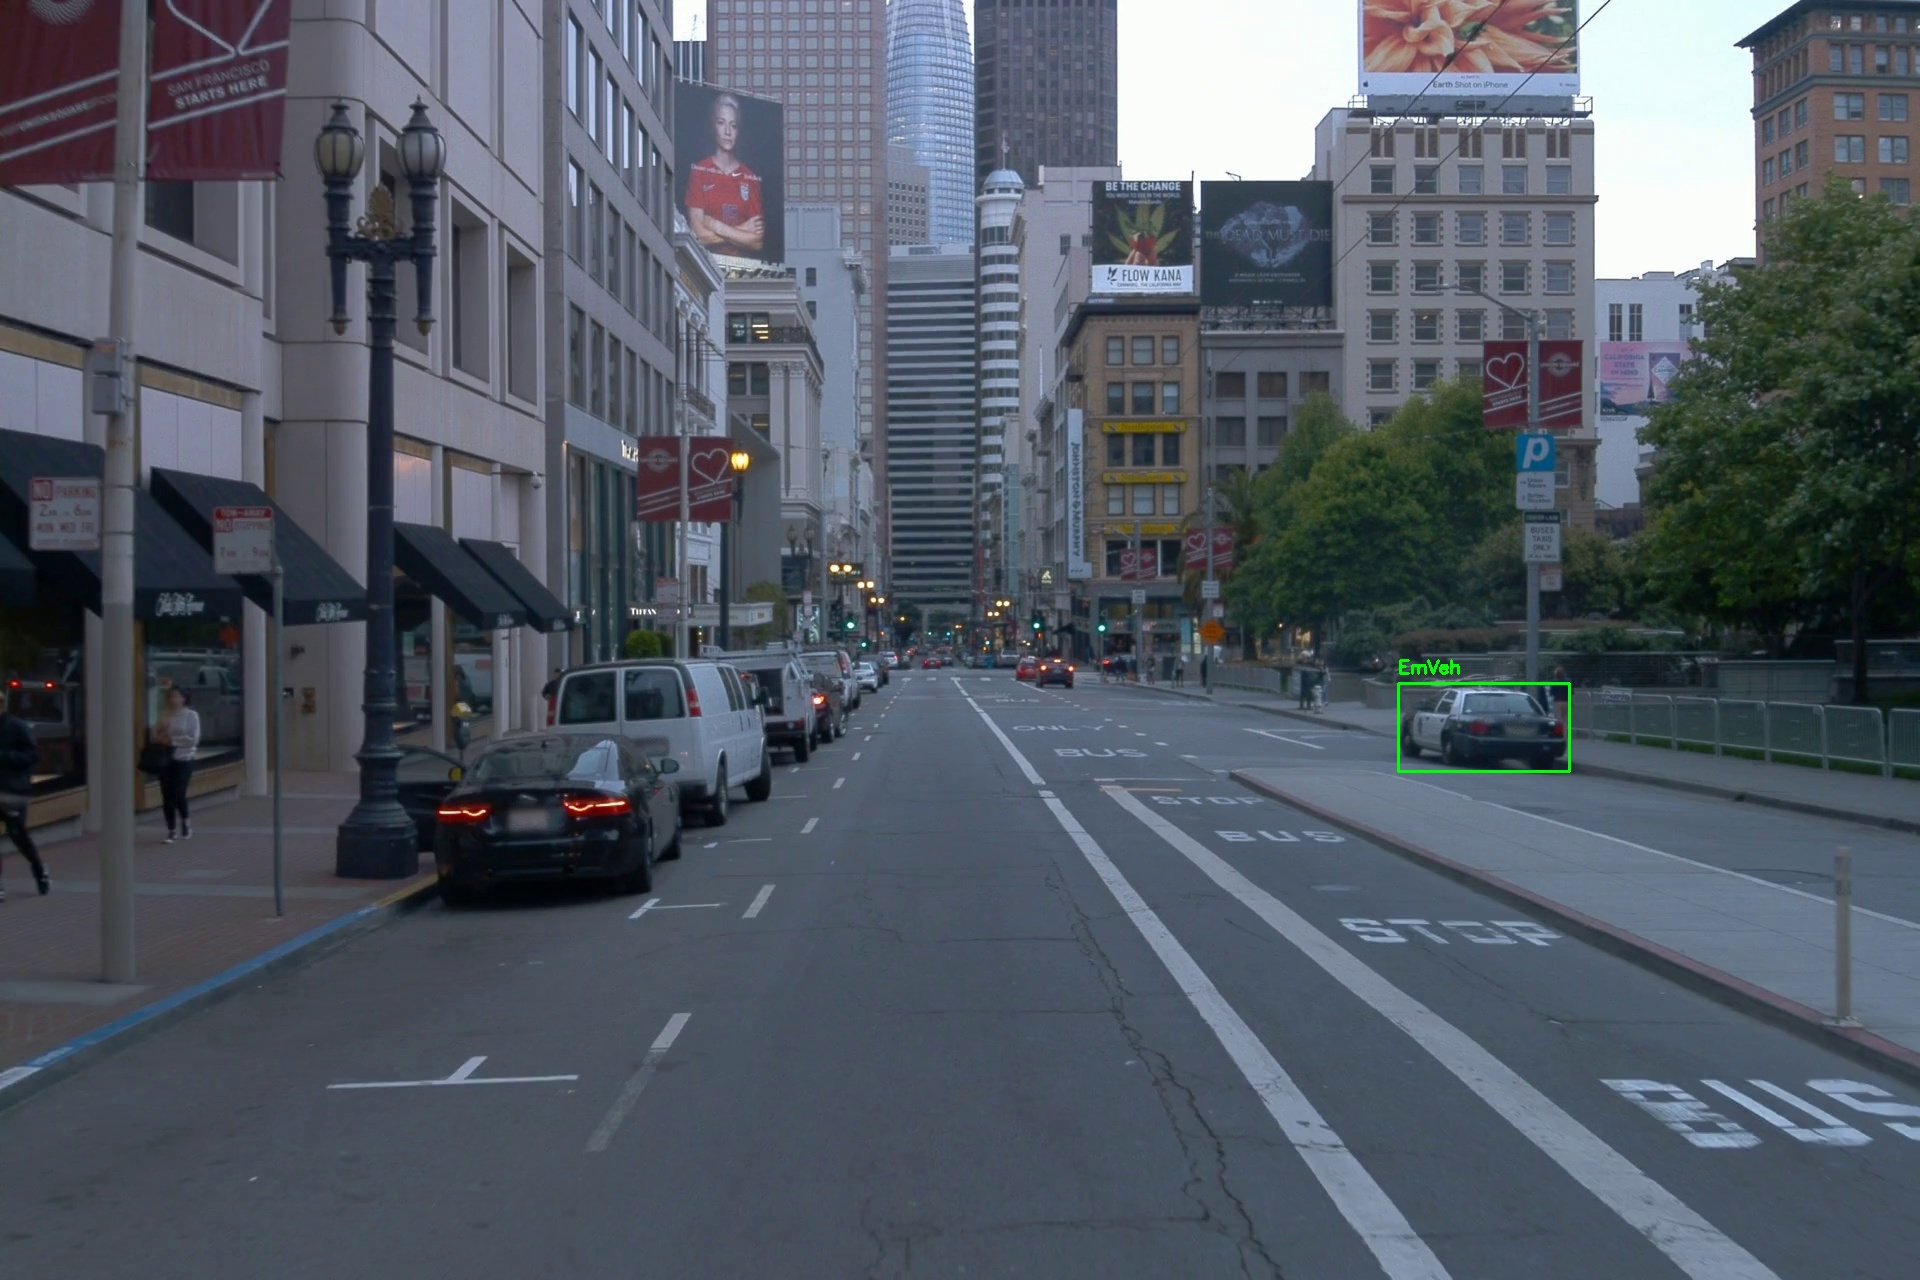

train_00581_11.jpg: 1 objects


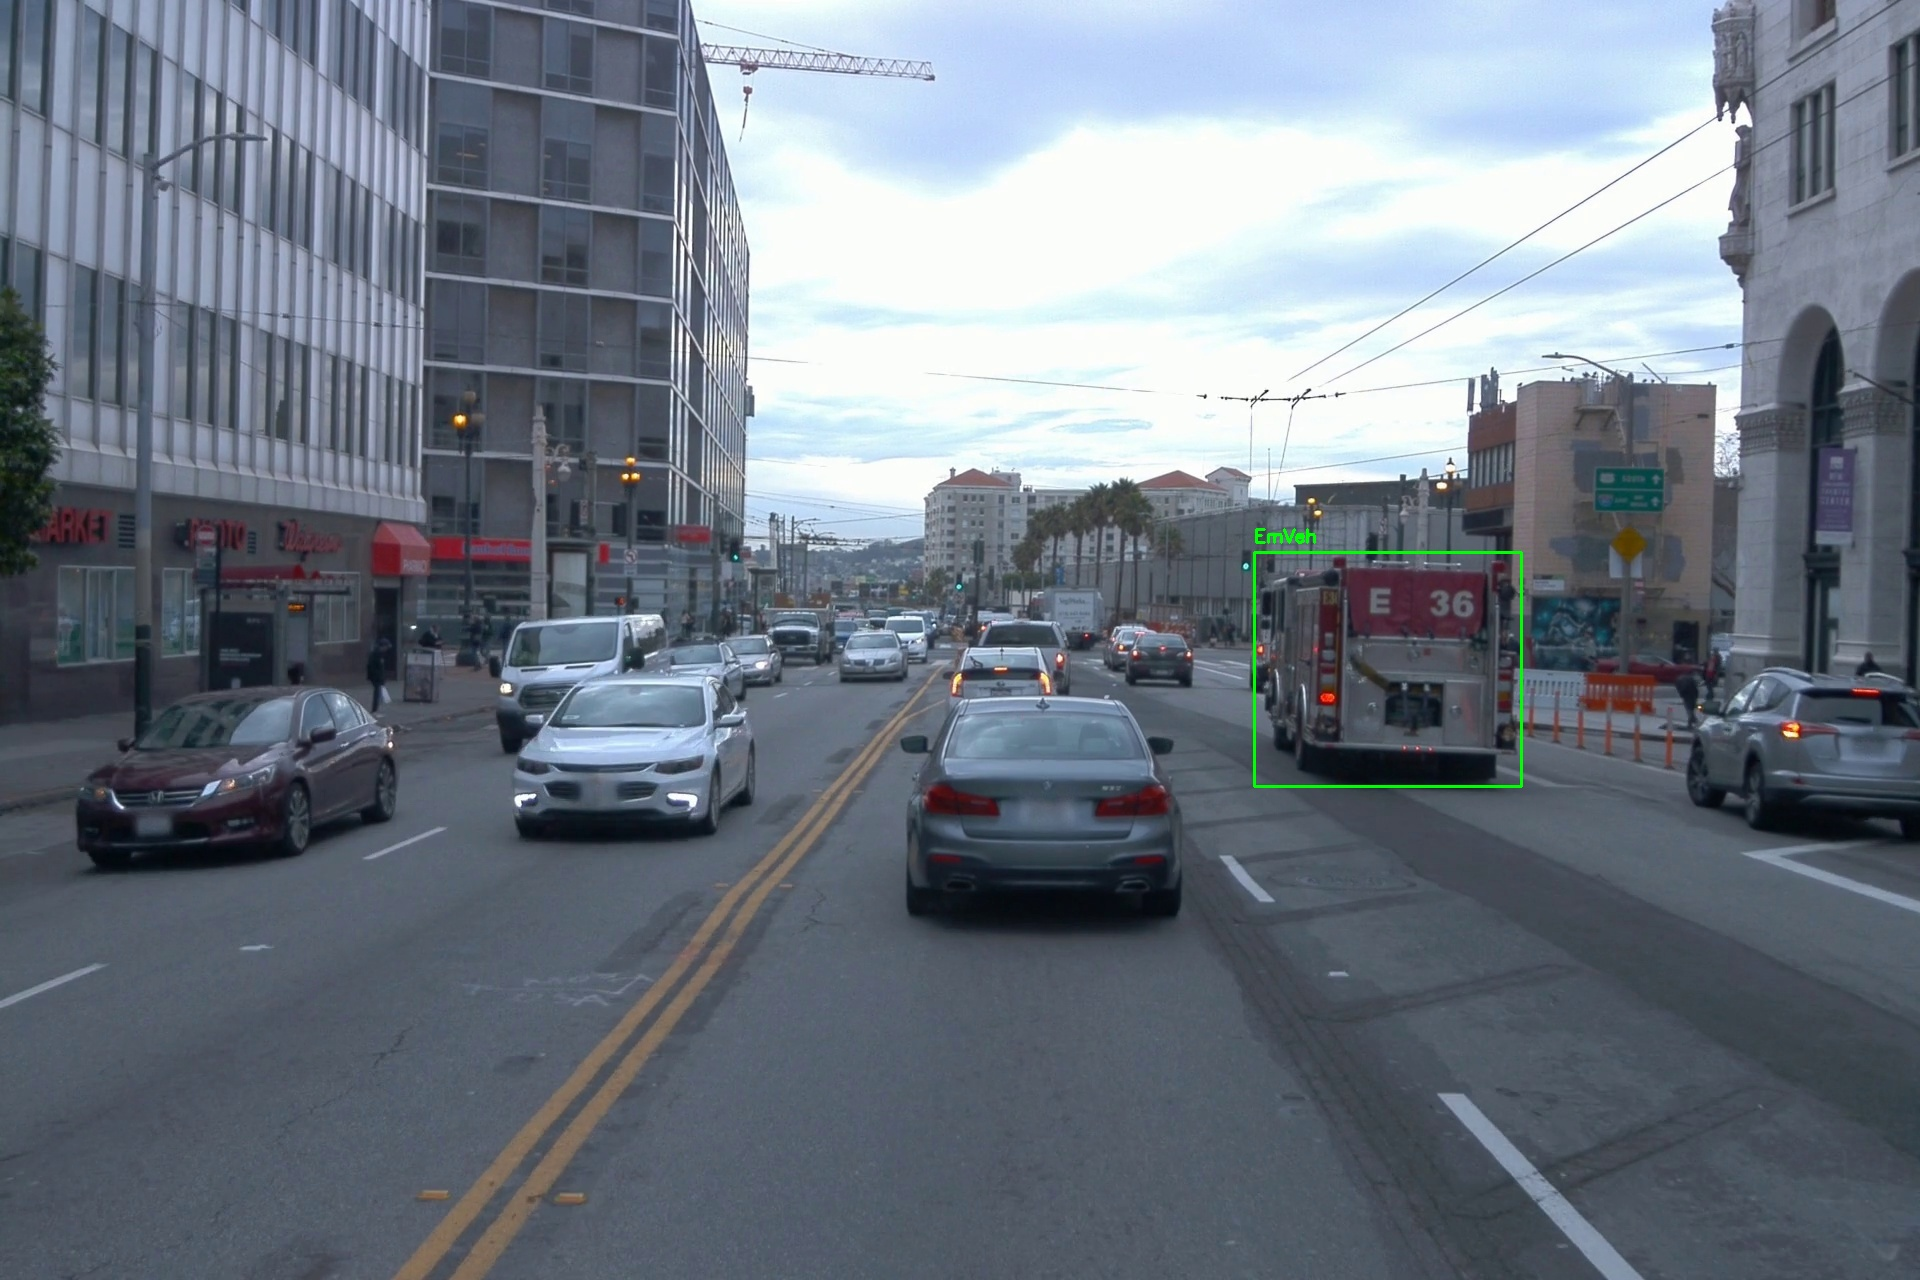

train_00430_134.jpg: 1 objects


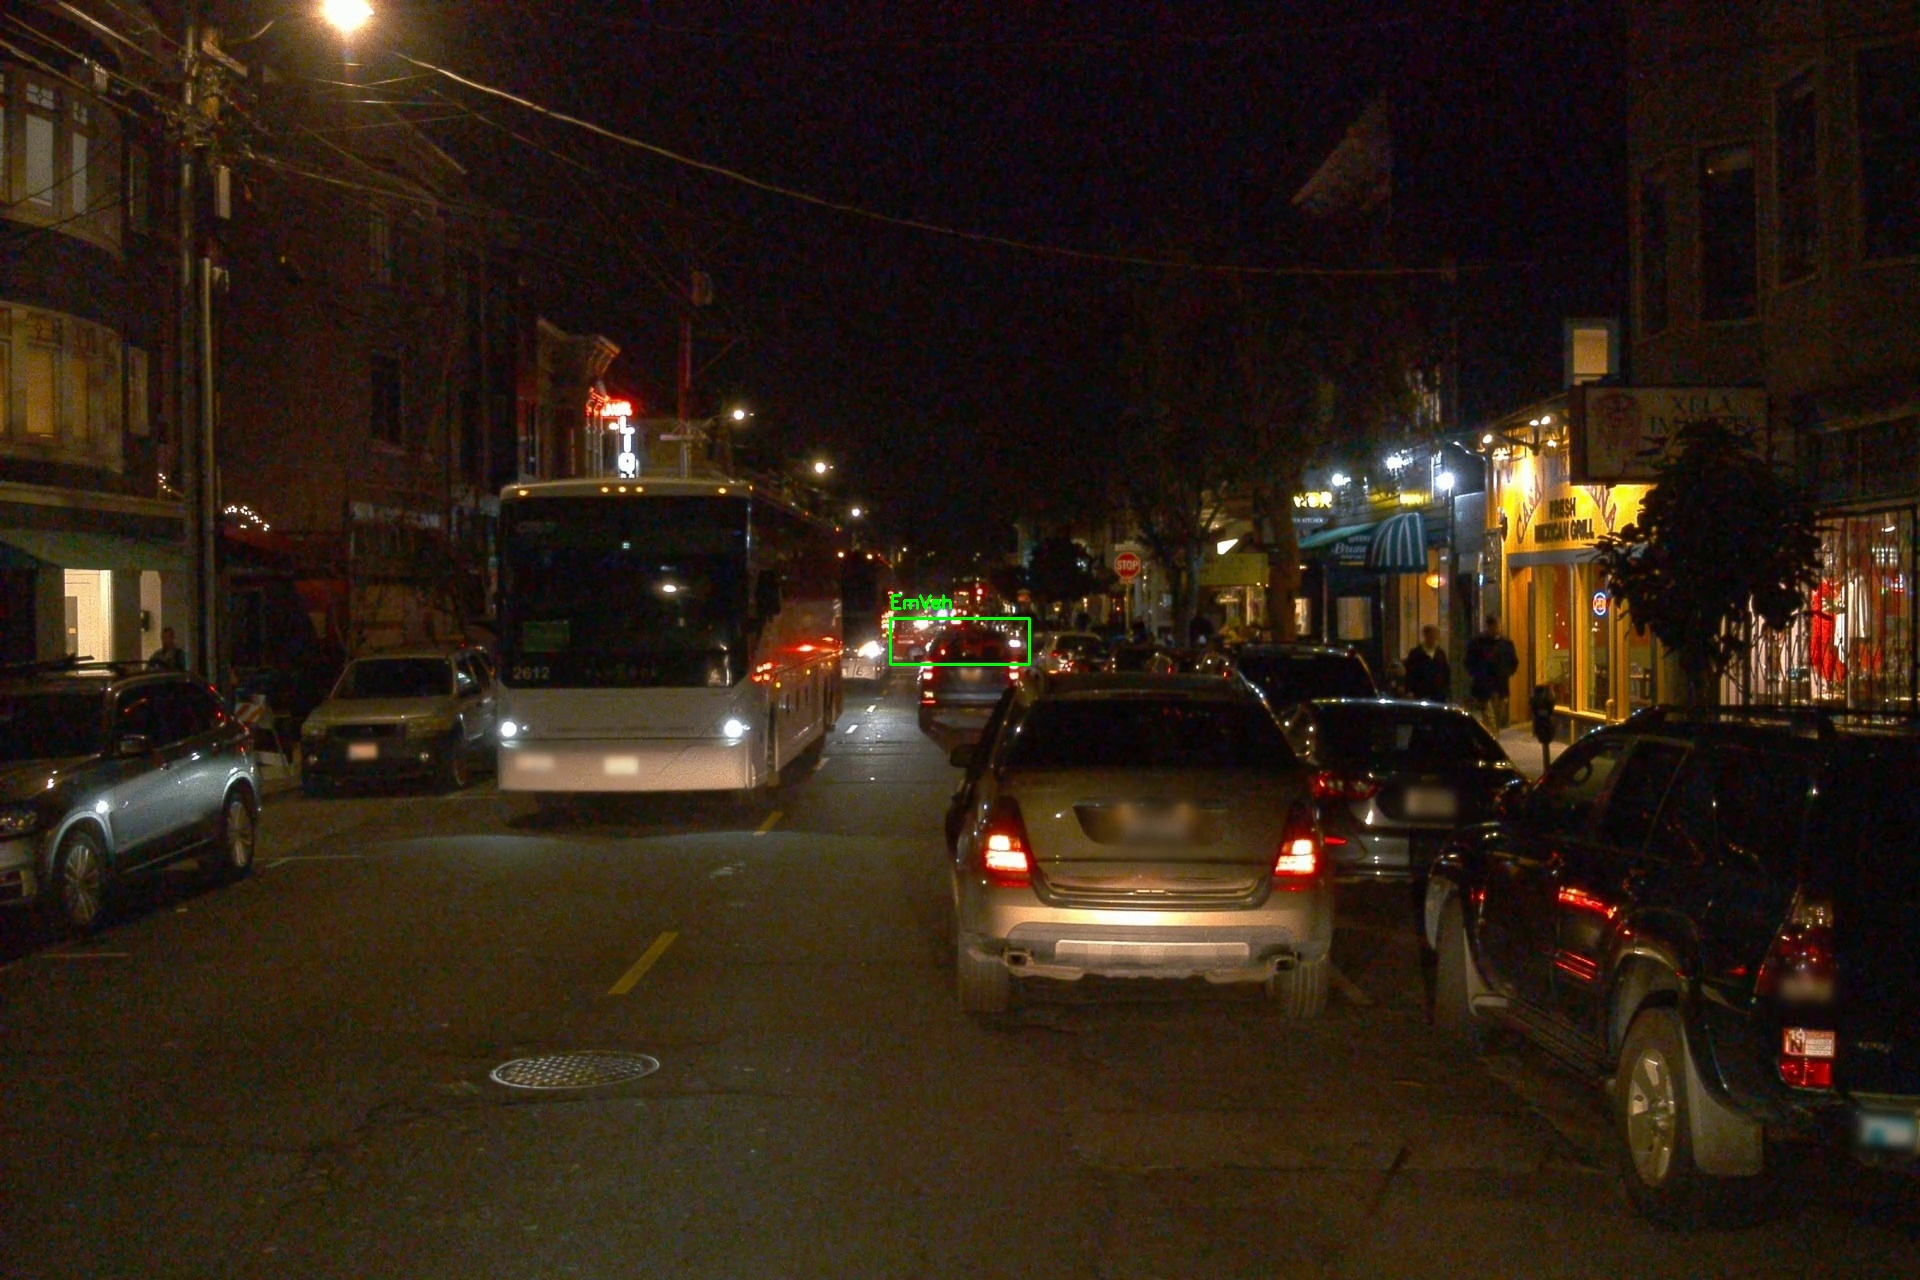

train_00560_81.jpg: 1 objects


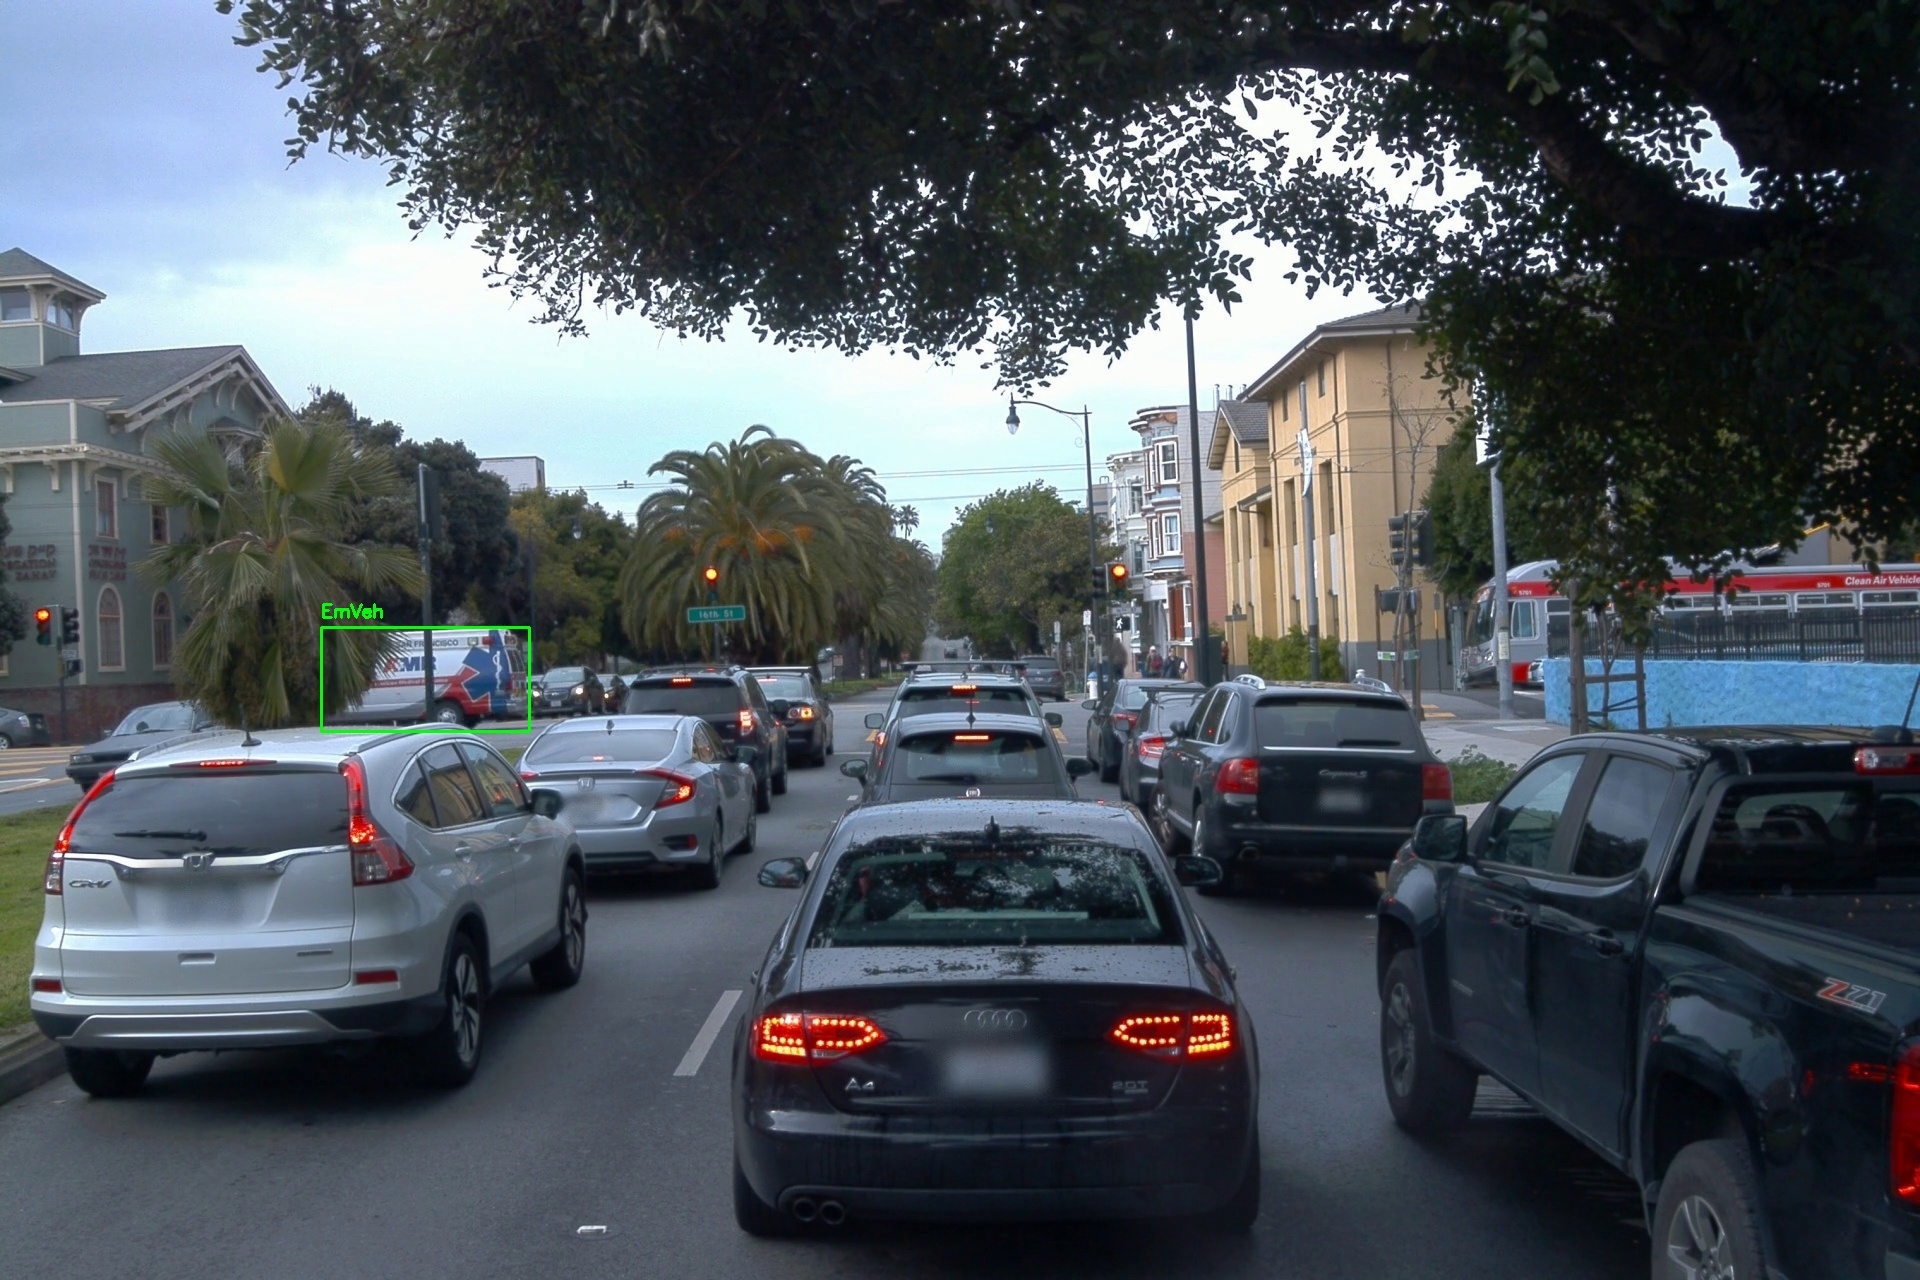

train_00430_127.jpg: 1 objects


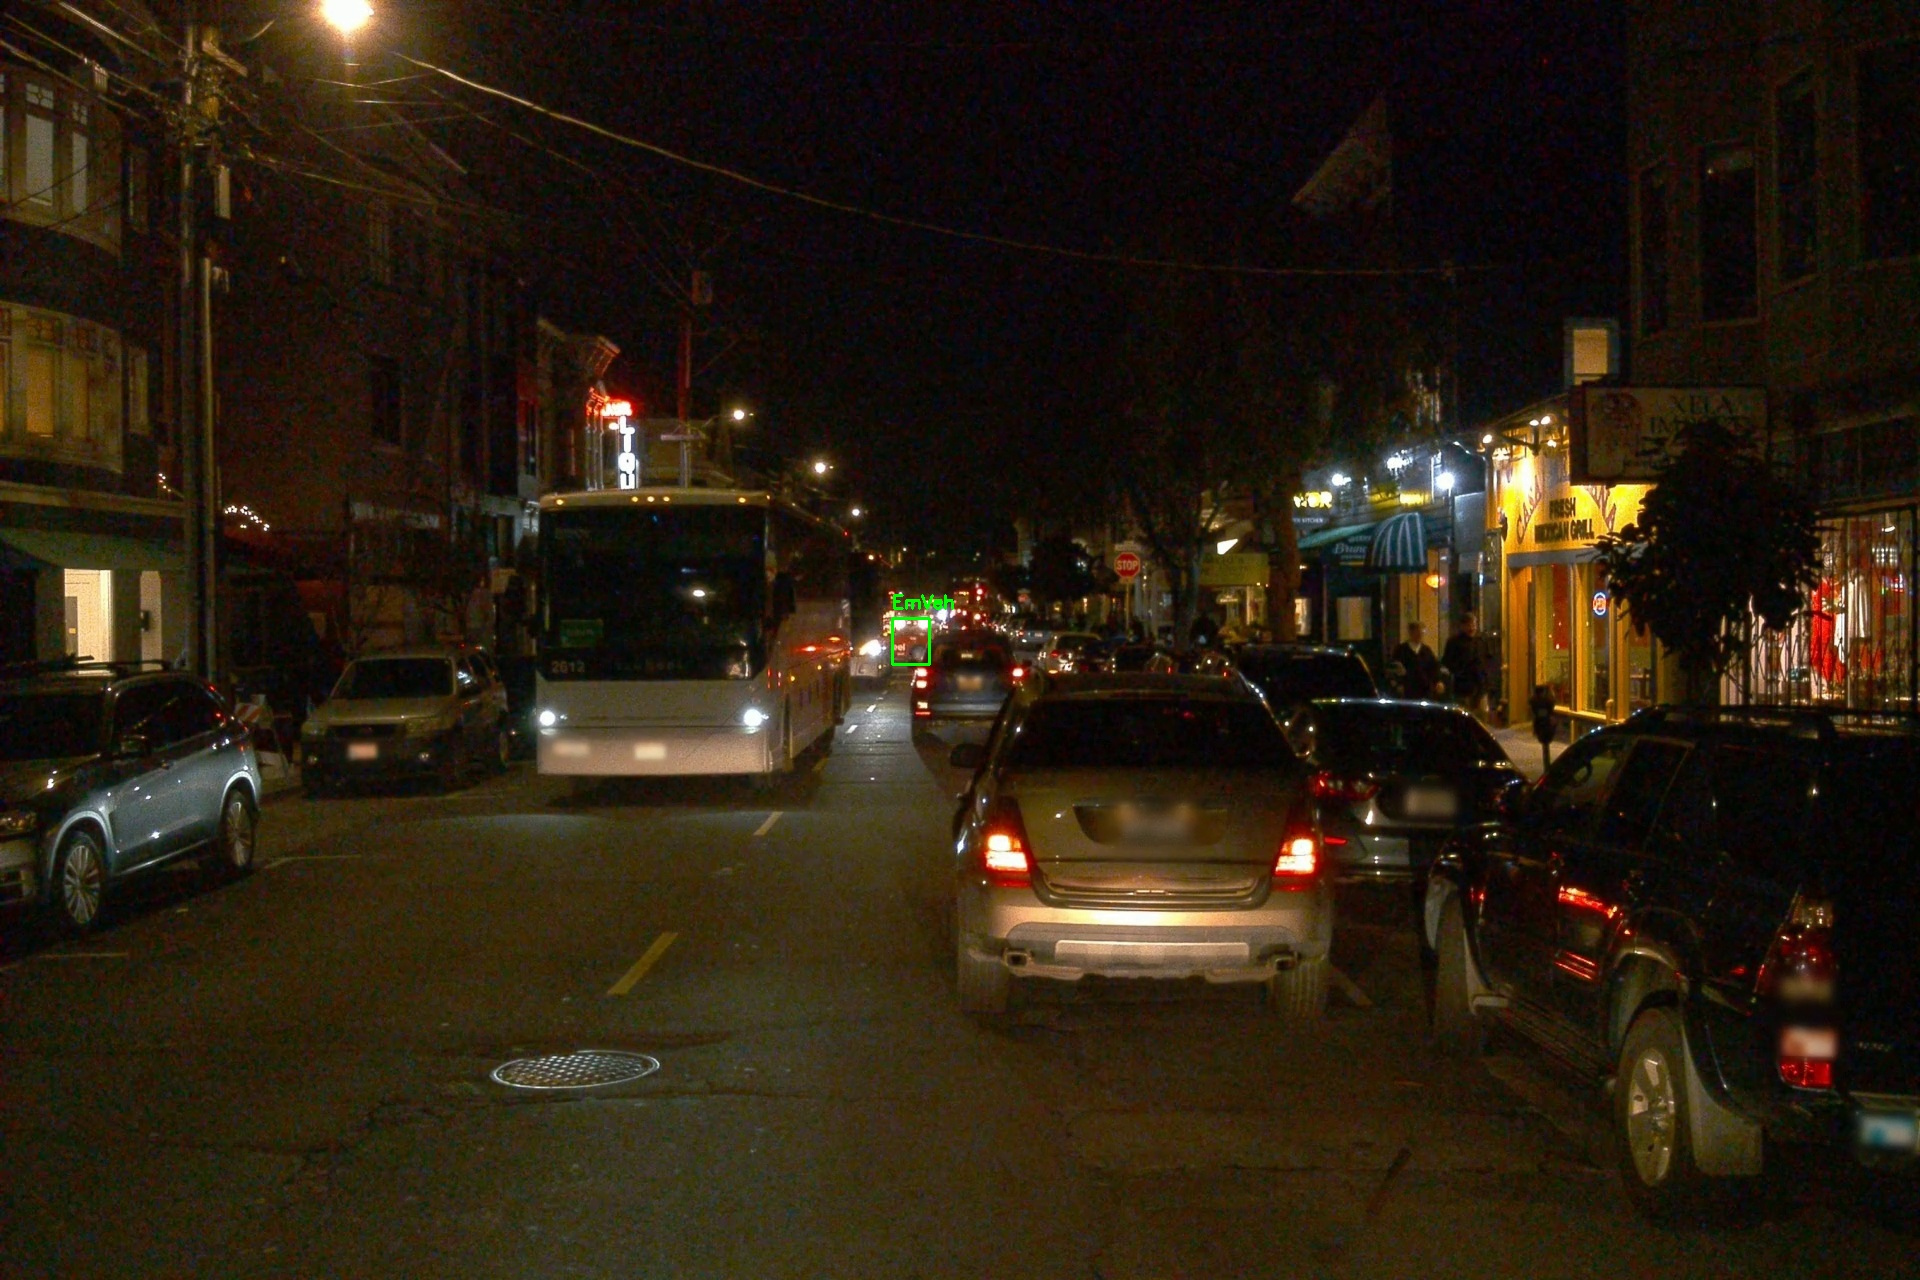


Displaying validation examples:
Dataset classes: ['EmVeh']
train_00647_9.jpg: 1 objects


train_00422_188.jpg: 1 objects


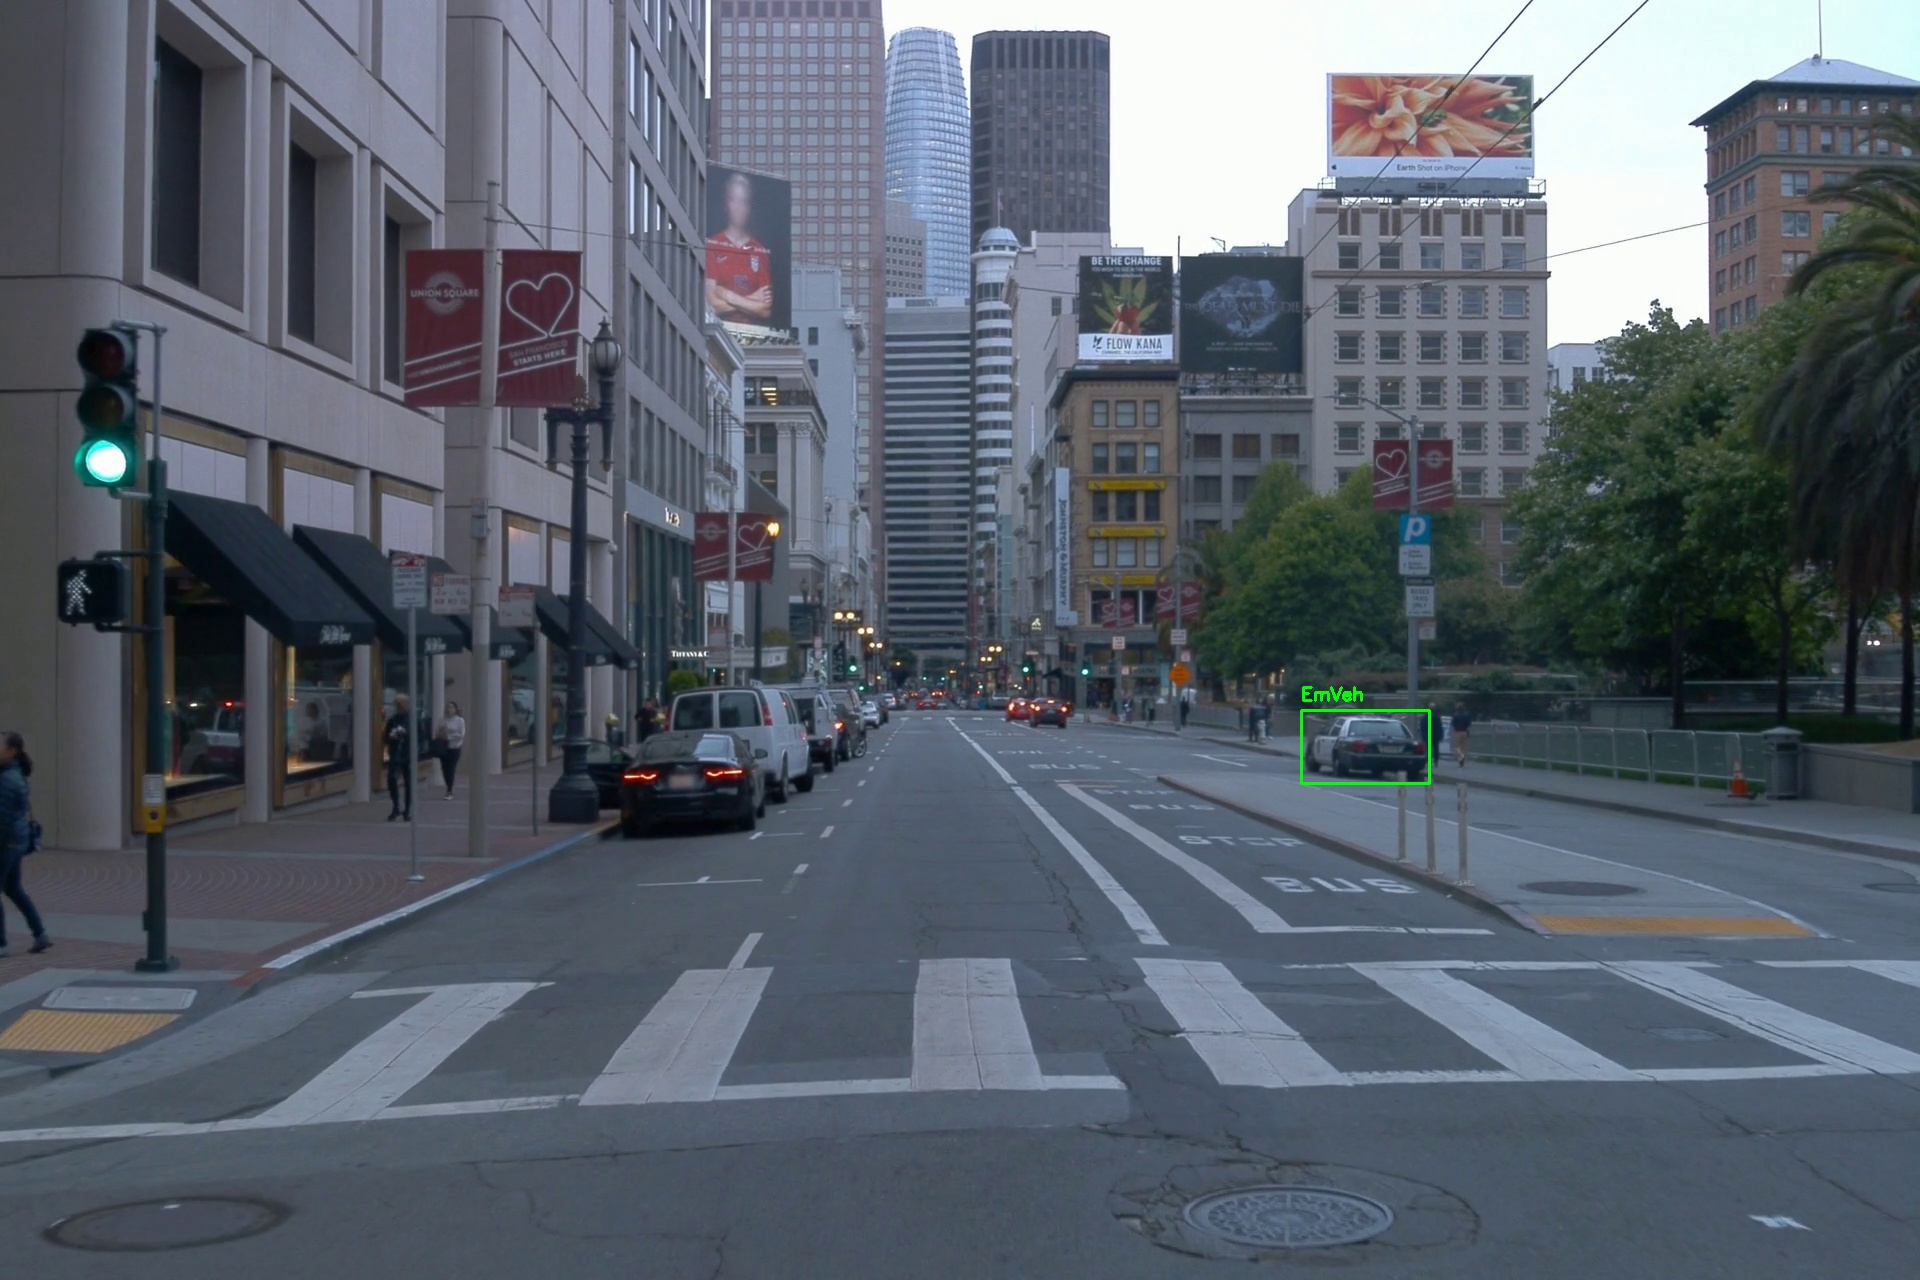

AttributeError: 'NoneType' object has no attribute 'shape'

In [14]:
# Add this function to your existing script to display dataset examples
def display_dataset_examples(num_examples=5, split='train'):
    """
    Display annotated examples from the YOLO dataset

    Args:
        num_examples: Number of examples to display
        split: 'train' or 'val'
    """
    import random

    # Load dataset config to get class names
    with open(os.path.join(YOLO_DIR, 'dataset.yaml'), 'r') as f:
        dataset_config = yaml.safe_load(f)

    class_names = dataset_config.get('names', [])
    if isinstance(class_names, dict):
        class_names = [class_names[i] for i in sorted(class_names.keys())]

    print(f"Dataset classes: {class_names}")

    # Define paths
    images_dir = os.path.join(YOLO_DIR, split, 'images')
    labels_dir = os.path.join(YOLO_DIR, split, 'labels')

    # Get random image files
    image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    selected_files = random.sample(image_files, min(num_examples, len(image_files)))

    # Colors for different classes
    colors = [(0, 255, 0), (255, 0, 0), (0, 0, 255), (255, 255, 0),
              (255, 0, 255), (0, 255, 255), (128, 0, 128), (255, 165, 0)]

    for image_file in selected_files:
        # Load image
        image_path = os.path.join(images_dir, image_file)
        image = cv2.imread(image_path)
        img_height, img_width = image.shape[:2]

        # Load corresponding annotation
        annotation_file = os.path.splitext(image_file)[0] + '.txt'
        annotation_path = os.path.join(labels_dir, annotation_file)

        # Draw annotations if they exist
        if os.path.exists(annotation_path):
            with open(annotation_path, 'r') as f:
                lines = f.readlines()

            object_count = 0
            for line in lines:
                line = line.strip()
                if line:
                    parts = line.split()
                    class_id = int(parts[0])
                    center_x = float(parts[1])
                    center_y = float(parts[2])
                    width = float(parts[3])
                    height = float(parts[4])

                    # Convert YOLO format to pixel coordinates
                    x1 = int((center_x - width/2) * img_width)
                    y1 = int((center_y - height/2) * img_height)
                    x2 = int((center_x + width/2) * img_width)
                    y2 = int((center_y + height/2) * img_height)

                    # Draw bounding box
                    color = colors[class_id % len(colors)]
                    cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

                    # Draw label
                    label = class_names[class_id] if class_id < len(class_names) else f"Class_{class_id}"
                    cv2.putText(image, label, (x1, y1-10),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
                    object_count += 1

            print(f"{image_file}: {object_count} objects")
        else:
            print(f"{image_file}: No annotations found")

        # Save and display
        output_path = os.path.join(RESULTS_DIR, f"dataset_example_{image_file}")
        cv2.imwrite(output_path, image)
        display(Image(filename=output_path))

# Add this to your main execution section:
if __name__ == "__main__":
    # ... your existing code ...

    # Add this after loading the dataset config:
    print("Displaying dataset examples with ground truth annotations:")
    display_dataset_examples(num_examples=5, split='train')

    # You can also display validation examples:
    print("\nDisplaying validation examples:")
    display_dataset_examples(num_examples=3, split='val')

# YOLO Training

## Small YOLO Model

In [9]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [10]:
import os
import yaml
from ultralytics import YOLO
from IPython.display import display, Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab import drive

# Define directories
BASE_DIR = "/content/waymo_emergency_vehicle_detection"
YOLO_DIR = os.path.join(BASE_DIR, "yolo_dataset")
RESULTS_DIR = os.path.join(BASE_DIR, "results")

# Create results directory
os.makedirs(RESULTS_DIR, exist_ok=True)

# Load dataset configuration
with open(os.path.join(YOLO_DIR, 'dataset.yaml'), 'r') as f:
    dataset_config = yaml.safe_load(f)

# Function to train YOLOv8 model
def train_yolo_model(model_size='n', epochs=50, batch_size=16, imgsz=640, patience=10):
    """
    Train a YOLOv8 model on our emergency vehicle dataset

    Args:
        model_size: Model size - 'n', 's', 'm', 'l', or 'x' (default: 'n')
        epochs: Number of training epochs (default: 50)
        batch_size: Batch size (default: 16)
        imgsz: Image size (default: 640)
        patience: Early stopping patience (default: 10)

    Returns:
        Trained model
    """
    # Load a pre-trained YOLOv8 model
    model = YOLO(f'yolov8{model_size}.pt')

    # Train the model
    results = model.train(
        data=os.path.join(YOLO_DIR, 'dataset.yaml'),
        epochs=epochs,
        batch=batch_size,
        imgsz=imgsz,
        patience=patience,
        save=True,
        project=RESULTS_DIR,
        name=f'yolov8{model_size}_emergency_vehicles',
        exist_ok=True,

    )

    return model, results

def evaluate_model(model):
    """
    Evaluate the trained model on the validation set

    Args:
        model: Trained YOLOv8 model
    """
    # Run validation
    results = model.val(
        data=os.path.join(YOLO_DIR, 'dataset.yaml')
    )

    # Display metrics
    metrics = results.box.map    # Mean Average Precision

    # Handle array metrics correctly
    if hasattr(results.box, 'p') and hasattr(results.box.p, 'mean'):
        precision = results.box.p.mean()
    else:
        precision = float(results.box.p) if hasattr(results.box, 'p') else 0

    if hasattr(results.box, 'r') and hasattr(results.box.r, 'mean'):
        recall = results.box.r.mean()
    else:
        recall = float(results.box.r) if hasattr(results.box, 'r') else 0

    if hasattr(results.box, 'f1') and hasattr(results.box.f1, 'mean'):
        f1 = results.box.f1.mean()
    else:
        f1 = float(results.box.f1) if hasattr(results.box, 'f1') else 0

    print(f"Model Performance Metrics:")
    print(f"mAP@0.5:0.95: {metrics:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return results

# Function to visualize predictions on sample images
def visualize_predictions(model, num_samples=5):
    """
    Visualize model predictions on sample validation images

    Args:
        model: Trained YOLOv8 model
        num_samples: Number of samples to visualize (default: 5)
    """
    # Get validation image paths
    val_images_dir = os.path.join(YOLO_DIR, 'val', 'images')
    image_files = [os.path.join(val_images_dir, f) for f in os.listdir(val_images_dir) if f.endswith('.jpg')]

    if len(image_files) == 0:
        print("No validation images found")
        return

    # Select random samples
    if len(image_files) > num_samples:
        image_files = np.random.choice(image_files, num_samples, replace=False)

    # Run predictions and visualize
    for img_path in image_files:
        # Run prediction
        results = model.predict(img_path, conf=0.25)

        # Generate and display visualization
        fig_path = os.path.join(RESULTS_DIR, f"pred_{os.path.basename(img_path)}")

        # Get the raw prediction image with bounding boxes
        result_img = results[0].plot()
        cv2.imwrite(fig_path, result_img)

        # Display the image
        display(Image(filename=fig_path))

        # Print detection details
        boxes = results[0].boxes
        print(f"Image: {os.path.basename(img_path)}")
        print(f"Detections: {len(boxes)}")

        if len(boxes) > 0:
            print("Confidence scores:", [f"{conf:.2f}" for conf in boxes.conf.tolist()])
        print("\n")

# Function to run inference on test videos
def run_inference_on_videos(model, num_videos=2, frame_skip=10):
    """
    Run inference on test videos and create visualization videos

    Args:
        model: Trained YOLOv8 model
        num_videos: Number of videos to process (default: 2)
        frame_skip: Process every Nth frame for speed (default: 10)
    """
    # Get list of video files
    videos_dir = os.path.join(BASE_DIR, "data", "videos")
    all_videos = [os.path.join(videos_dir, f) for f in os.listdir(videos_dir) if f.endswith('.mp4')]

    # Select random videos
    if len(all_videos) > num_videos:
        videos = np.random.choice(all_videos, num_videos, replace=False)
    else:
        videos = all_videos

    for video_path in videos:
        video_name = os.path.basename(video_path)
        output_path = os.path.join(RESULTS_DIR, f"pred_{video_name}")

        print(f"Processing video: {video_name}")

        # Open video
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Could not open video: {video_path}")
            continue

        # Get video properties
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Create video writer
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps/frame_skip, (width, height))

        frame_count = 0
        processed_count = 0

        # Process frames
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Process every frame_skip frames
            if frame_count % frame_skip == 0:
                # Run prediction
                results = model.predict(frame, conf=0.25)

                # Draw predictions on frame
                result_frame = results[0].plot()

                # Write frame to output video
                out.write(result_frame)
                processed_count += 1

                # Print progress
                if processed_count % 10 == 0:
                    print(f"Processed {processed_count} frames ({frame_count}/{total_frames})")

            frame_count += 1

        # Release resources
        cap.release()
        out.release()

        print(f"Video saved to {output_path}")

# Main execution
if __name__ == "__main__":
    # Install the required packages
    !pip install ultralytics

    # Step 1: Train the model
    print("Step 1: Training YOLOv8 model...")
    model, training_results = train_yolo_model(
        model_size='s',    # 's' for small, faster training
        epochs=25,         # Reduce for faster training, increase for better performance
        batch_size=16,     # Adjust based on available memory
        imgsz=640,         # Standard YOLO image size
        patience=5         # Early stopping patience
    )

    # Step 2: Evaluate the model
    print("\nStep 2: Evaluating model performance...")
    evaluation_results = evaluate_model(model)

    # Step 3: Visualize predictions on sample images
    print("\nStep 3: Visualizing predictions on sample images...")
    visualize_predictions(model, num_samples=5)

    # Step 4: Run inference on test videos
    print("\nStep 4: Running inference on test videos...")
    run_inference_on_videos(model, num_videos=2, frame_skip=5)

    print("\nModel training and evaluation complete!")

    # Optional: Save results to Google Drive
    drive.mount('/content/drive')
    save_dir = '/content/drive/MyDrive/emergency_vehicle_detection'
    os.makedirs(save_dir, exist_ok=True)

    # Copy result files
    !cp -r {RESULTS_DIR}/* {save_dir}/
    print(f"Results saved to Google Drive: {save_dir}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


FileNotFoundError: [Errno 2] No such file or directory: '/content/waymo_emergency_vehicle_detection/yolo_dataset/dataset.yaml'

### Testing

In [ ]:
import os
from ultralytics import YOLO
from IPython.display import display, Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define directories
BASE_DIR = "/content/waymo_emergency_vehicle_detection"
YOLO_DIR = os.path.join(BASE_DIR, "yolo_dataset")
RESULTS_DIR = os.path.join(BASE_DIR, "results")
MODEL_DIR = os.path.join(RESULTS_DIR, "yolov8s_emergency_vehicles")
WEIGHTS_DIR = os.path.join(MODEL_DIR, "weights")

# Path to your trained model
model_path = os.path.join(WEIGHTS_DIR, "best.pt")  # Adjust filename if different

# Load the model
model = YOLO(model_path)
print(f"Model loaded from {model_path}")

# Function to test on single image
def test_on_single_image(image_path, conf=0.25):
    """Test model on a single image and display results"""
    # Run prediction
    results = model.predict(image_path, conf=conf, save=True)[0]

    # Get and display the result image
    result_image = results.plot()
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Predictions on {os.path.basename(image_path)}")
    plt.show()

    # Print detection details
    boxes = results.boxes
    print(f"Found {len(boxes)} emergency vehicles")

    if len(boxes) > 0:
        print("\nDetection details:")
        for i, box in enumerate(boxes):
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            confidence = box.conf[0].item()
            print(f"Detection {i+1}: Confidence: {confidence:.4f}, Coordinates: [{int(x1)}, {int(y1)}, {int(x2)}, {int(y2)}]")

    return results

# Function to process a video
def test_on_video(video_path, output_path=None, conf=0.25):
    """Process a video with the trained model"""
    if output_path is None:
        # Create output directory if it doesn't exist
        output_dir = os.path.join(RESULTS_DIR, "video_tests")
        os.makedirs(output_dir, exist_ok=True)

        # Generate output filename
        video_name = os.path.basename(video_path)
        output_path = os.path.join(output_dir, f"detected_{video_name}")

    # Run prediction on video
    results = model.predict(
        source=video_path,
        conf=conf,
        save=True,
        project=os.path.dirname(output_path),
        name=os.path.basename(output_path).split('.')[0]
    )

    print(f"Video processing complete. Output saved to: {output_path}")
    return output_path

# Function to evaluate on validation set
def evaluate_on_val_set():
    """Evaluate model performance on validation set"""
    # Define validation data path
    val_data = os.path.join(YOLO_DIR, "dataset.yaml")

    # Run validation
    results = model.val(data=val_data)

    # Extract and print metrics
    metrics = results.box.map    # Mean Average Precision
    precision = results.box.p.mean() if hasattr(results.box.p, 'mean') else float(results.box.p)
    recall = results.box.r.mean() if hasattr(results.box.r, 'mean') else float(results.box.r)
    f1 = results.box.f1.mean() if hasattr(results.box.f1, 'mean') else float(results.box.f1)

    print(f"\nModel Performance Metrics:")
    print(f"mAP@0.5:0.95: {metrics:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return results

# Function to batch process test samples
def test_on_sample_images(num_samples=5, conf=0.25):
    """Test on multiple random samples from validation set"""
    # Get validation images
    val_images_dir = os.path.join(YOLO_DIR, 'val', 'images')
    image_files = [os.path.join(val_images_dir, f) for f in os.listdir(val_images_dir) if f.endswith('.jpg')]

    if len(image_files) == 0:
        print("No validation images found")
        return

    # Select random samples
    if len(image_files) > num_samples:
        selected_images = random.sample(image_files, num_samples)
    else:
        selected_images = image_files

    # Process each image
    for img_path in selected_images:
        print(f"\nProcessing image: {os.path.basename(img_path)}")
        test_on_single_image(img_path, conf=conf)

Model loaded from /content/waymo_emergency_vehicle_detection/results/yolov8s_emergency_vehicles/weights/best.pt


In [ ]:
# 1. Evaluate model on the validation set
#print("Evaluating model on validation set...")
#evaluate_on_val_set()  # Use cli_evaluate_on_val_set() for CLI approach

# 2. Test on random sample images
#print("\nTesting on random sample images...")
#test_on_sample_images(num_samples=3, conf=0.25)  # Use cli_test_on_sample_images() for CLI approach

# 3. Test on a specific image
#print("\nTesting on a specific image...")
#specific_image = os.path.join(YOLO_DIR, 'val', 'images', 'train_00164_135.jpg')  # Adjust to an actual image path
#test_on_single_image(specific_image, conf=0.25)  # Use cli_test_on_image() for CLI approach

# 4. Process a video
#print("\nProcessing a test video...")
video_path = os.path.join(BASE_DIR, "data", "videos", "train_00599.mp4")  # Adjust to an actual video
test_on_video(video_path, conf=0.25)  # Use cli_test_on_video() for CLI approach


WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/198) /content/waymo_emergency_vehicle_detection/data/videos/train_00599.mp4: 448x640 (no detections), 10.0ms
video 1/1 (frame 2/198) /content/waymo_emergency_vehicle_detection/data/videos/train_00599.mp4: 448x640 (no detections), 8.5ms
video 1/1 (frame 3/198) /content/waymo_emergency_vehicle_detection/data/videos/train_00599.mp4: 448x640 (no detections), 8.5ms
video 1/1 (frame 4/198) /content/waymo_emergency_vehicle_detection/data/vi

'/content/waymo_emergency_vehicle_detection/results/video_tests/detected_train_00599.mp4'

## Medium YOLO Model (NOT WORKING YET)

In [ ]:
import os
import yaml
import cv2
import numpy as np
from IPython.display import display, Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import time

# Define directories
BASE_DIR = "/content/waymo_emergency_vehicle_detection"
YOLO_DIR = os.path.join(BASE_DIR, "yolo_dataset")
RESULTS_DIR = os.path.join(BASE_DIR, "results")
MODEL_DIR = os.path.join(RESULTS_DIR, "models")

# Create necessary directories
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

# Function to train using os.system to ensure progress is visible
def train_yolo_model_cli(model_size='m', epochs=100, batch_size=8, imgsz=1280, patience=15):
    """Train a YOLOv8 model with visible progress"""
    model_path = f"yolov8{model_size}.pt"
    project_dir = os.path.join(RESULTS_DIR, f"yolov8{model_size}_run")

    # Build the command
    cmd = [
        "yolo", "detect", "train",
        f"model={model_path}",
        f"data={os.path.join(YOLO_DIR, 'dataset.yaml')}",
        f"epochs={epochs}",
        f"imgsz={imgsz}",
        f"batch={batch_size}",
        f"patience={patience}",
        f"project={project_dir}",
        "name=train",
        "exist_ok=True",
        "verbose=True"  # Ensure verbose output
    ]

    # Execute the command with os.system to show real-time progress
    cmd_str = " ".join(cmd)
    print(f"Running training command: {cmd_str}")

    # Using os.system ensures the output is displayed in real-time
    os.system(cmd_str)

    # Find the best weights path
    best_weights_path = os.path.join(project_dir, "train", "weights", "best.pt")
    if os.path.exists(best_weights_path):
        # Copy to our models directory with a descriptive name
        target_path = os.path.join(MODEL_DIR, f"yolov8{model_size}_emveh_i{imgsz}_e{epochs}.pt")
        os.system(f"cp {best_weights_path} {target_path}")
        print(f"Best model saved to {target_path}")
        return target_path
    else:
        print("Warning: Could not find best weights file")
        return None

# Function to evaluate a model with visible progress
def evaluate_model_cli(weights_path):
    """Evaluate model with visible progress"""
    cmd = [
        "yolo", "detect", "val",
        f"model={weights_path}",
        f"data={os.path.join(YOLO_DIR, 'dataset.yaml')}",
        "verbose=True"  # Ensure verbose output
    ]

    cmd_str = " ".join(cmd)
    print(f"Running evaluation command: {cmd_str}")

    # Using os.system for real-time output
    os.system(cmd_str)

# Function to run predictions on sample images
def predict_on_samples(weights_path, num_samples=5):
    """Run predictions on sample images from validation set"""
    # Get validation images
    val_images_dir = os.path.join(YOLO_DIR, 'val', 'images')
    image_files = [os.path.join(val_images_dir, f) for f in os.listdir(val_images_dir) if f.endswith('.jpg')]

    if len(image_files) == 0:
        print("No validation images found")
        return

    # Select random samples
    if len(image_files) > num_samples:
        selected_images = random.sample(image_files, num_samples)
    else:
        selected_images = image_files

    # Create output directory for visualizations
    vis_dir = os.path.join(RESULTS_DIR, "visualizations")
    os.makedirs(vis_dir, exist_ok=True)

    # Save sample paths to a temporary file
    with open("/tmp/sample_images.txt", "w") as f:
        for img_path in selected_images:
            f.write(f"{img_path}\n")

    # Run prediction with visible progress
    cmd = [
        "yolo", "detect", "predict",
        f"model={weights_path}",
        f"source=/tmp/sample_images.txt",
        "save=True",
        f"project={vis_dir}",
        "conf=0.25",
        "exist_ok=True",
        "verbose=True"  # Ensure verbose output
    ]

    cmd_str = " ".join(cmd)
    print(f"Running prediction command: {cmd_str}")
    os.system(cmd_str)

    # Display results
    pred_dir = os.path.join(vis_dir, "predict")
    if os.path.exists(pred_dir):
        result_images = [os.path.join(pred_dir, f) for f in os.listdir(pred_dir) if f.endswith('.jpg')]
        for img_path in result_images:
            display(Image(filename=img_path))
            print(f"Visualization: {os.path.basename(img_path)}")

# Function to process a test video with visible progress
def process_test_video(weights_path, num_videos=1):
    """Process a test video with visible progress"""
    # Get list of video files
    videos_dir = os.path.join(BASE_DIR, "data", "videos")
    all_videos = [os.path.join(videos_dir, f) for f in os.listdir(videos_dir) if f.endswith('.mp4')]

    if not all_videos:
        print("No videos found for inference")
        return

    # Select random videos
    if len(all_videos) > num_videos:
        selected_videos = random.sample(all_videos, num_videos)
    else:
        selected_videos = all_videos

    # Create output directory
    vid_output_dir = os.path.join(RESULTS_DIR, "video_predictions")
    os.makedirs(vid_output_dir, exist_ok=True)

    # Process each video
    for video_path in selected_videos:
        video_name = os.path.basename(video_path)
        print(f"Processing video: {video_name}")

        # Run prediction with visible progress
        cmd = [
            "yolo", "detect", "predict",
            f"model={weights_path}",
            f"source={video_path}",
            "save=True",
            f"project={vid_output_dir}",
            "conf=0.25",
            "exist_ok=True",
            "verbose=True"  # Ensure verbose output
        ]

        cmd_str = " ".join(cmd)
        print(f"Running video prediction command: {cmd_str}")
        os.system(cmd_str)

        print(f"Video prediction complete: {video_name}")

# Main execution
if __name__ == "__main__":
    # Fix for potential CUDA errors
    import gc
    import torch
    torch.cuda.empty_cache()
    gc.collect()

    # Step 1: Train the model with visible progress
    print("\n=== Step 1: Training YOLOv8 Model ===")
    print("Training will start in 5 seconds - Progress will be visible")
    time.sleep(5)  # Give a moment to see the message

    model_weights = train_yolo_model_cli(
        model_size='m',         # Medium model for better accuracy
        epochs=50,              # 50 epochs should be enough
        batch_size=8,           # Reduced batch size for higher resolution
        imgsz=1280,             # Higher resolution for better small object detection
        patience=15             # Increased patience for better convergence
    )

    if model_weights and os.path.exists(model_weights):
        # Step 2: Evaluate the model
        print("\n=== Step 2: Evaluating Model Performance ===")
        evaluate_model_cli(model_weights)

        # Step 3: Run predictions on sample images
        print("\n=== Step 3: Generating Sample Predictions ===")
        predict_on_samples(model_weights, num_samples=5)

        # Step 4: Process a test video
        print("\n=== Step 4: Processing Test Video ===")
        process_test_video(model_weights, num_videos=1)

        print("\nAll tasks completed successfully!")
    else:
        print("Model training failed or model weights not found.")


=== Step 1: Training YOLOv8 Model ===
Training will start in 5 seconds - Progress will be visible
Running training command: yolo detect train model=yolov8m.pt data=/content/waymo_emergency_vehicle_detection/yolo_dataset/dataset.yaml epochs=50 imgsz=1280 batch=8 patience=15 project=/content/waymo_emergency_vehicle_detection/results/yolov8m_run name=train exist_ok=True verbose=True
Best model saved to /content/waymo_emergency_vehicle_detection/results/models/yolov8m_emveh_i1280_e50.pt

=== Step 2: Evaluating Model Performance ===
Running evaluation command: yolo detect val model=/content/waymo_emergency_vehicle_detection/results/models/yolov8m_emveh_i1280_e50.pt data=/content/waymo_emergency_vehicle_detection/yolo_dataset/dataset.yaml verbose=True

=== Step 3: Generating Sample Predictions ===
Running prediction command: yolo detect predict model=/content/waymo_emergency_vehicle_detection/results/models/yolov8m_emveh_i1280_e50.pt source=/tmp/sample_images.txt save=True project=/content/